# 時系列解析入門

# **6. 多変量時系列モデルと長期予測への応用 (60分)**
この章では、時系列データ解析における代表的なモデルについて解説します。各モデルの特性を理解することで、データの特性や分析目的に応じて、最適なモデルを選び効果的に活用するための具体的なイメージを得ましょう。

# <font color="DarkOrange">1. VAR（ベクトル自己回帰モデル）</font>

## <font color="SeaGreen">VAR（Vector Autoregressive Model）とは</font>
複数の時系列データ間の相互関係を同時にモデル化する自己回帰モデルです。<br>
経済や金融データが代表的な例です。
GDP、失業率、インフレ率などは、それぞれが単独で変動するだけでなく、お互いに影響を与え合うことがあります。また、株価や為替レートも、複数の市場が連動することが多いです。<font color="red">VARモデルでは、複数の時系列データ間の相互依存関係を考慮して各変数が他の変数にどのような影響を与えるかをモデル化し、より現実的な未来のデータを予測することができます。</font>

In [ ]:
!pip install statsmodels

では、2つの関連する時系列データを使ってVARモデルを構築し、予測を行います。
まずは、サンプルデータを作成し、可視化します。

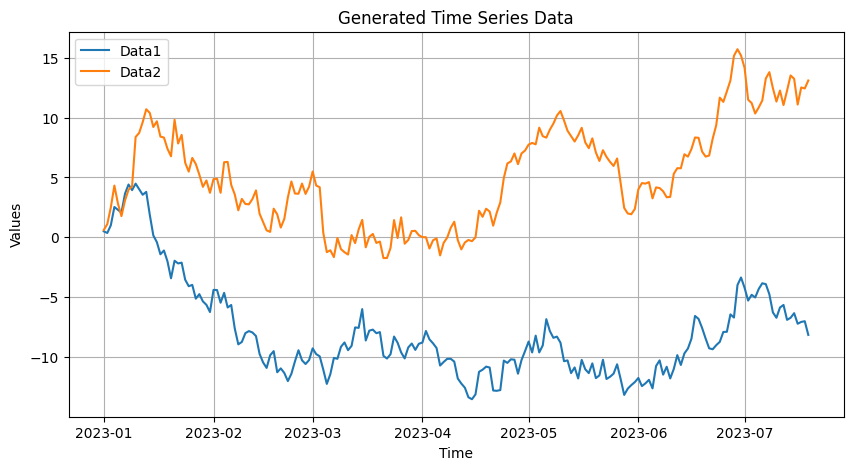

In [ ]:
# Step 1: シミュレーションデータの作成
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 時系列データを作成（200期間のデータ）
np.random.seed(42)
time = pd.date_range(start="2023-01-01", periods=200, freq="D")

# 例: 2つの時系列データをシミュレーション
data1 = np.cumsum(np.random.normal(0, 1, 200))  # ランダムウォーク1
data2 = np.cumsum(np.random.normal(0, 1, 200)) + 0.5 * data1  # 相関を持たせたデータ

# データフレームに格納
df = pd.DataFrame({"Data1": data1, "Data2": data2}, index=time)

# データの可視化
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Data1'], label="Data1")
plt.plot(df.index, df['Data2'], label="Data2")
plt.title("Generated Time Series Data")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# データの確認
df.head()

,Data1,Data2
2023-01-01,0.496714,0.606144
2023-01-02,0.358450,1.097797
2023-01-03,1.006138,2.504692
2023-01-04,2.529168,4.320009
2023-01-05,2.295015,2.825263


次に、VARモデルを構築します。<br>
VARモデルとは、複数の時系列データ間の相互関係を捉えながら未来の値を予測するモデルの1つで、各時系列データの値が、過去の自分自身や他のデータの値に依存する形でモデル化されます。<br>
モデル化の際には、予測に必要な過最適な**ラグ次数（過去データのどの時点まで遡って使うか）**をAICを使って自動的に決定しています。AICはモデルの複雑さと精度のバランスを考慮した指標で、数値が小さいほど良いモデルと判断されます。
- ラグ次数とは？<br>
時系列データのモデルでは、現在の値が過去のデータに依存して決定される場合があります。ラグ次数は、その過去に遡る時点数を示します。たとえば、ラグが3なら、現在の値を決定するのに3つ前までのデータが使用されます。

In [ ]:
# Step 2: VARモデルの構築とフィッティング
from statsmodels.tsa.api import VAR

# モデルの構築
model = VAR(df)

# VARモデルにおいて、最適なラグ次数（過去データのどの時点まで遡って使うか）を選択する
# 引数のmaxlags=15は、最大15時点前までのデータを調べ、その中から最適なラグを選ぶ
lag_order = model.select_order(maxlags=15)
print("Selected lag order:", lag_order.aic)

# 選択したラグ次数に基づいてVARモデルをデータにフィッティング（適合）させる
# フィッティング済みのVARモデルが変数model_fittedに格納され、後の残差分析や予測に使用される
model_fitted = model.fit(lag_order.aic)

# モデルの概要
print("----- model info -----")
print(model_fitted.summary())


Selected lag order: 1
----- model info -----
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Feb, 2025
Time:                     13:16:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0721950
Nobs:                     199.000    HQIC:                 -0.131303
Log likelihood:          -541.674    FPE:                   0.842412
AIC:                    -0.171491    Det(Omega_mle):        0.817576
--------------------------------------------------------------------
Results for equation Data1
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.268916         0.193932           -1.387           0.166
L1.Data1         0.965923         0.017232           56.055           0.000
L1.Data2        -0.008699         0

フィッティング済みのモデルから**残差（residuals）**を取得します。<br>
残差が正規分布に近いかどうかを調べるのは、モデルがデータの特徴を適切に捉えているかどうかを確認するために、残差の分布をヒストグラムとして可視化します。

- 残差とは？<br>
実際の観測値とモデルが予測した値との差を示します。
良いモデルは、予測が実際のデータにほぼ一致するため、残差が平均0付近に集まり、極端に大きい差がほとんどないことが理想です。
残差が小さいほど、モデルが正確にデータを捉えていることを意味します。

- ヒストグラムの目的<br>
残差が正規分布（平均0を中心に左右対称の分布）に近いかを視覚的に確認します。残差が**正規分布**に近ければ、モデルがうまくデータを捉えていると判断できます。

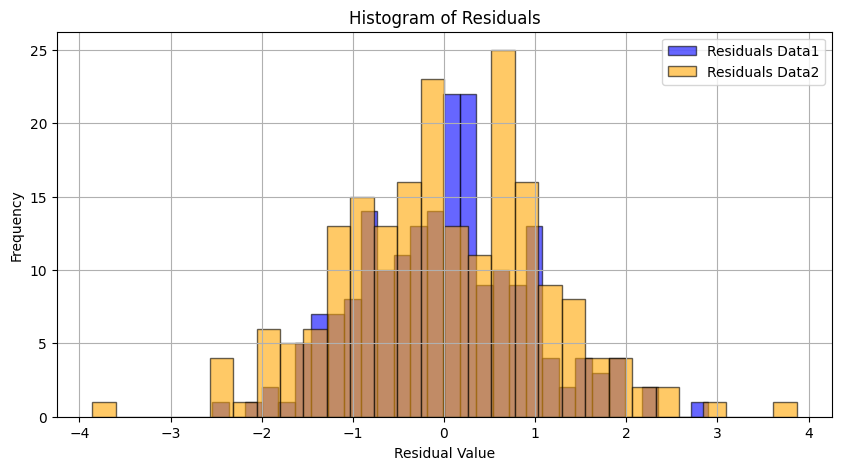

In [ ]:
# Step 3: 残差の取得とヒストグラムのプロット
residuals = model_fitted.resid

plt.figure(figsize=(10, 5))
plt.hist(residuals["Data1"], bins=30, alpha=0.6, label="Residuals Data1", color="blue", edgecolor="black")
plt.hist(residuals["Data2"], bins=30, alpha=0.6, label="Residuals Data2", color="orange", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Step 4: MSEとRMSEの計算
from sklearn.metrics import mean_squared_error

# 実際の残差と理想的な残差（すべて0）との間の**MSE（平均二乗誤差）**を計算
# [0] * len(residuals["Data1"])で理想的な残差（すべて0）を作成しています。このリストの長さは、Data1の残差の数と同じになります。
mse_data1 = mean_squared_error([0] * len(residuals["Data1"]), residuals["Data1"])
mse_data2 = mean_squared_error([0] * len(residuals["Data2"]), residuals["Data2"])

rmse_data1 = np.sqrt(mse_data1)
rmse_data2 = np.sqrt(mse_data2)

print("MSE for Data1:", mse_data1)
print("RMSE for Data1:", rmse_data1)
print("MSE for Data2:", mse_data2)
print("RMSE for Data2:", rmse_data2)

MSE for Data1: 0.841320266959561
RMSE for Data1: 0.9172351208711761
MSE for Data2: 1.258734456527559
RMSE for Data2: 1.1219333565446563


5ステップ先（step=5）までの予測を実行します。<br>
実際のデータは実線で、予測データは破線（linestyle="dashed"）で描画します。

            Data1_Pred  Data2_Pred
2023-07-20   -8.259166   12.888283
2023-07-21   -8.358750   12.685539
2023-07-22   -8.453176   12.488201
2023-07-23   -8.542669   12.296158
2023-07-24   -8.627441   12.109302


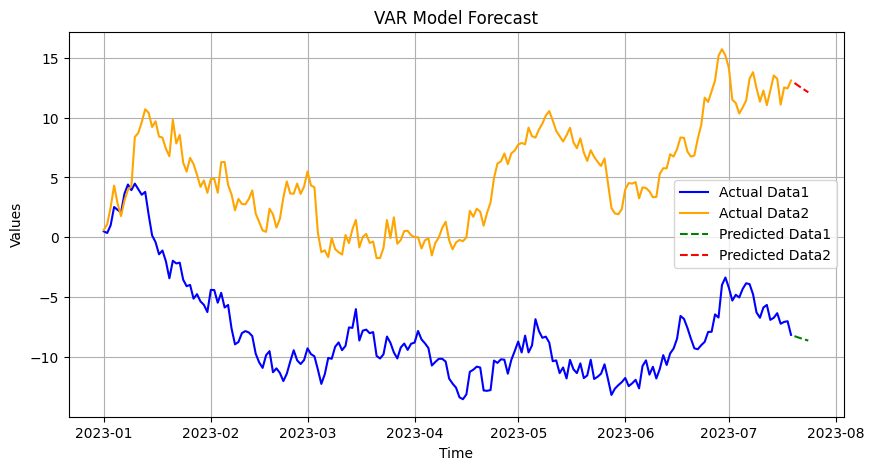

In [ ]:
# Step 5: 予測を実施し、実際のデータと予測結果の可視化
# 5ステップ先までの予測
# df.values[-lag_order.aic:]は、最適なラグ次数だけ遡った直近のデータをモデルに入力として与える
# これにより、未来の5日間分のData1とData2の予測値が得られる
forecast = model_fitted.forecast(df.values[-lag_order.aic:], steps=5)

# 結果をデータフレームに格納
# 日時インデックスは直近の日付から5日間分を生成し、予測データはData1_PredとData2_Predという名前で管理
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=5),
                           columns=["Data1_Pred", "Data2_Pred"])

# 予測結果を表示
print(forecast_df)

# 実際のデータと予測データを可視化
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Data1"], label="Actual Data1", color="blue")
plt.plot(df.index, df["Data2"], label="Actual Data2", color="orange")
plt.plot(forecast_df.index, forecast_df["Data1_Pred"], label="Predicted Data1", color="green", linestyle="dashed")
plt.plot(forecast_df.index, forecast_df["Data2_Pred"], label="Predicted Data2", color="red", linestyle="dashed")
plt.title("VAR Model Forecast")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()


## まとめ
時系列データをの相関関係を分析を行い、複数の時系列データを同時に扱い、相互の影響を考慮した予測を行いました。また、残差分析、MSE、RMSEなどを使ってモデルの性能を定量的かつ視覚的に評価しました。

# <font color="DarkOrange">2. Prophet</font>

## <font color="SeaGreen">Prophetとは</font>
Metaが公開しているオープンソースの時系列解析ライブラリです。<br>
https://facebook.github.io/prophet/

Prophetは<font color="red">複雑なトレンド、季節性、祝日などのイベントの影響を自動的に分解してモデルを構築します。また、欠損値や外れ値を自動的に扱うことができるため、データの前処理がほとんど不要で手軽に高精度な予測が可能です。外れ値や非定常データにも柔軟に対応し、視覚的に分かりやすい出力を提供します。</font>現実のビジネスケースに対して有効な予測モデルを手軽に構築できます。

トレンド・周期性・イベント・ノイズをそれぞれでモデル化し足し合わせた**一般化加法モデル（Generalized Additive Model）**で、時間tにおける予測値y(t)は以下のように表されます。

$$y(t) = g(t) + s(t) + h(t) + ϵ(t)$$

g(t) はトレンド、s(t)は周期変動、h(t)は突発的なイベントが与える影響、ϵ(t)はノイズを表します。



公式の"Quick Start"を利用してProphetを試してみましょう。<br>
https://facebook.github.io/prophet/docs/quick_start.html#python-api

このデータは、Meta Prophetの公式サンプルデータとして提供されているPeyton Manningという有名なアメフト選手のWikipediaページの過去のページビュー時系列データで、時系列解析や予測モデルのデモンストレーションに使用されるものです。ページビュー数の季節性、イベントに基づく変動、トレンドなどの要因を分析するためによく用いられます。

具体的には、次のような情報が含まれています。

- 列1：ds
日付が記録されており、フォーマットは YYYY-MM-DD です。データは2007年12月10日から2016年1月20日まであります。

- 列2：y
対応する日のWikipediaページビュー数が格納されています。

まずはデータを読み込み可視化してみましょう。



In [ ]:
import pandas as pd
from prophet import Prophet
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


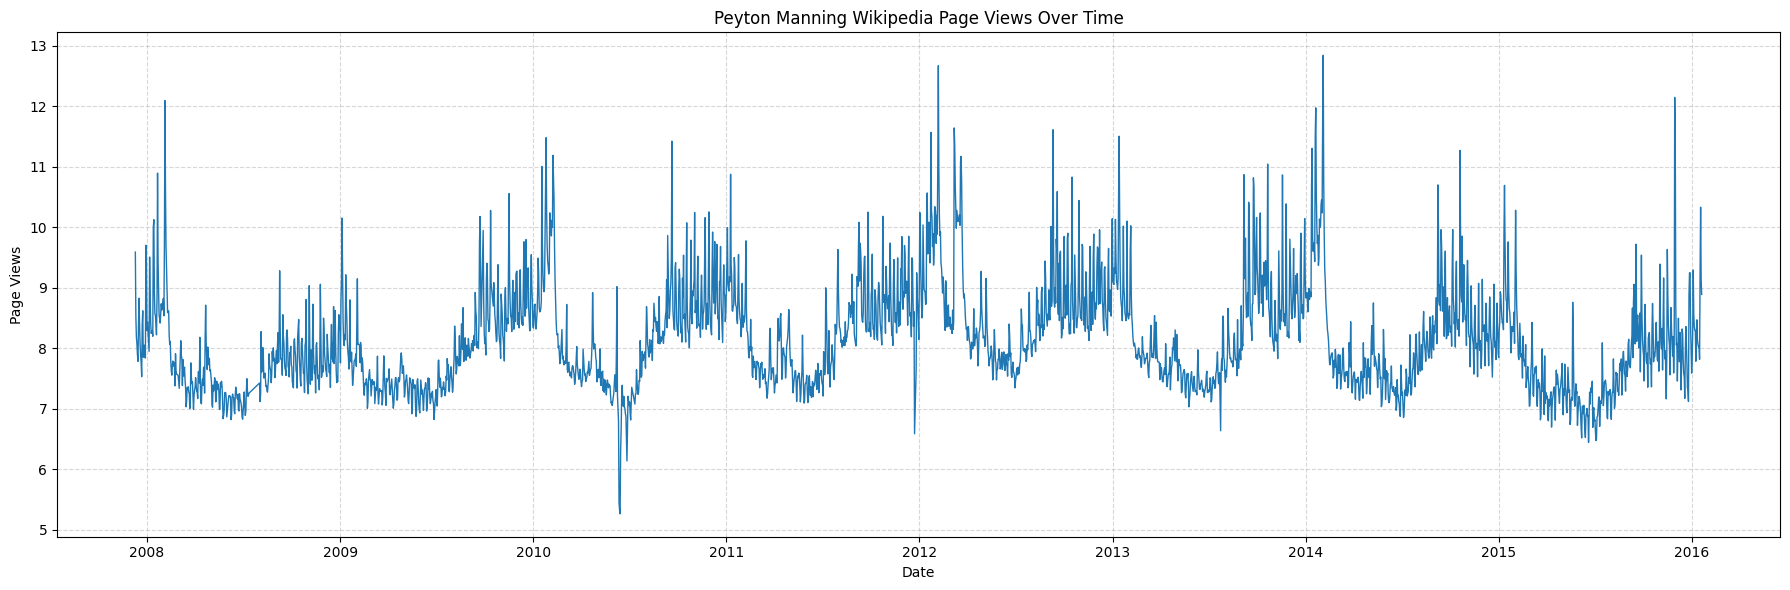

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 日付の型変換
df['ds'] = pd.to_datetime(df['ds'])

# プロットの設定
plt.figure(figsize=(18, 6))
plt.plot(df['ds'], df['y'], linewidth=1)
plt.title('Peyton Manning Wikipedia Page Views Over Time')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

次に予測精度を評価するため、データを学習データセットとテストデータセットに分割してデータを視覚的に確認します。<br>
今回は、学習データ：テストデータ = 7：3 とします。

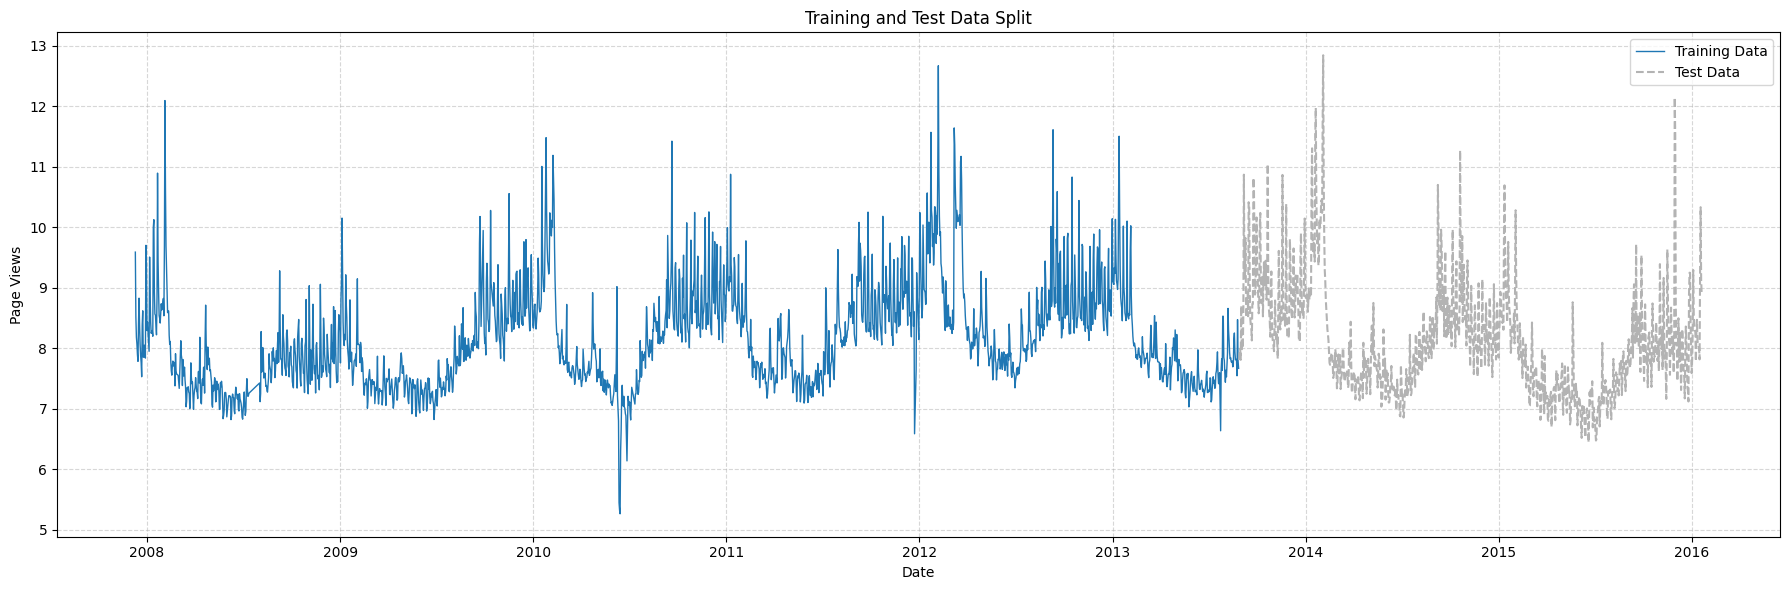

In [ ]:
# split data into train and test
from sklearn.model_selection import train_test_split
train_size = 0.7
train_df, test_df = train_test_split(df, train_size=train_size, shuffle=False)

# plot train and test data
plt.figure(figsize=(18, 6))
plt.plot(train_df['ds'], train_df['y'], label='Training Data', linewidth=1)
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color="0.7", linestyle='dashed')
plt.title('Training and Test Data Split')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Prophet モデルの作成と学習を行い予測してみます。

In [ ]:
# Prophet モデルのインスタンス化
model = Prophet()

# モデルの学習
model.fit(train_df)

# テストデータの期間に対する予測を行う。テストデータの期間に対応する未来データを作成
future = test_df[['ds']]

# 予測の実行
forecast = model.predict(future)
forecast.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/6h8eeczr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/vqdwwve4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60803', 'data', 'file=/tmp/tmpcfpvvmia/6h8eeczr.json', 'init=/tmp/tmpcfpvvmia/vqdwwve4.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model4poji0zs/prophet_model-20250212004029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-08-28,7.934896,7.309001,8.518128,7.934896,7.934896,-0.012760,-0.012760,-0.012760,-0.066304,-0.066304,-0.066304,0.053544,0.053544,0.053544,0.0,0.0,0.0,7.922136
1,2013-08-29,7.933109,7.338061,8.522550,7.933109,7.933109,0.003884,0.003884,0.003884,-0.077909,-0.077909,-0.077909,0.081793,0.081793,0.081793,0.0,0.0,0.0,7.936994
2,2013-08-30,7.931323,7.446646,8.577369,7.931323,7.931323,0.035712,0.035712,0.035712,-0.077228,-0.077228,-0.077228,0.112940,0.112940,0.112940,0.0,0.0,0.0,7.967034
3,2013-08-31,7.929536,7.234528,8.418140,7.929536,7.929536,-0.120681,-0.120681,-0.120681,-0.267347,-0.267347,-0.267347,0.146666,0.146666,0.146666,0.0,0.0,0.0,7.808855
4,2013-09-01,7.927749,7.631645,8.803459,7.927749,7.927749,0.259597,0.259597,0.259597,0.077026,0.077026,0.077026,0.182572,0.182572,0.182572,0.0,0.0,0.0,8.187346


dataframeにds以外の新しいカラムが追加されていて、yhatが予測値となります。

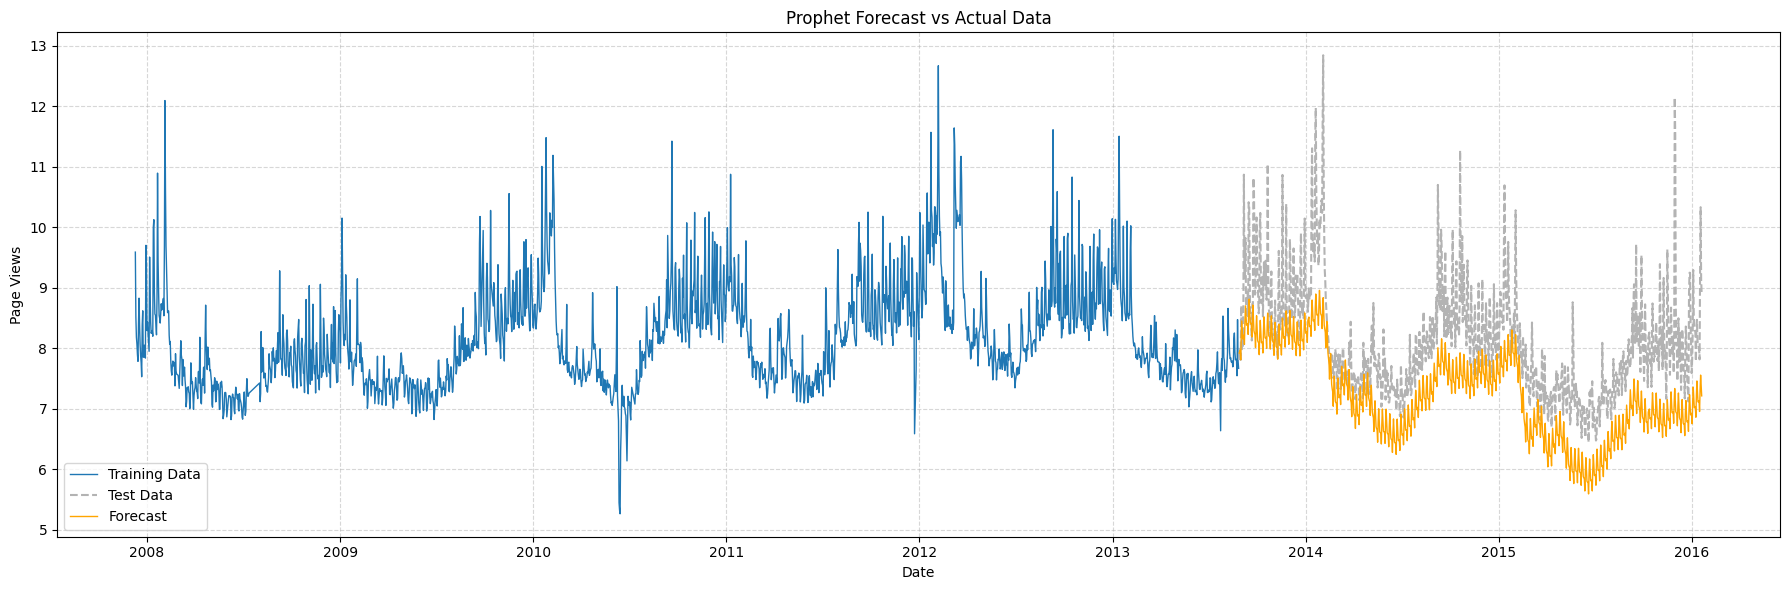

In [ ]:
# 予測結果と実データの可視化
plt.figure(figsize=(18, 6))
# 学習データ
plt.plot(train_df['ds'], train_df['y'], label='Training Data', linewidth=1)
# テストデータ
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='0.7', linestyle='dashed')
# 予測結果
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange', linewidth=1)

plt.title('Prophet Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

予測精度を評価するために、RMSE、MSE、MAE、MAPEを計算します。

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# 実測値と予測値を取得
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

# 各評価指標を計算
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# 結果を表示
print(f"MSE: {round(mse, 3)}")
print(f"RMSE: {round(rmse, 3)}")
print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}")

MSE: 1.069
RMSE: 1.034
MAE: 0.879
MAPE: 0.106


Prophetはデータのトレンドや季節性の要因を自動的に分解して分析できます。<br>
Prophet.plot_componemtsでcomponentごとに分解した可視化もできます。
分解図では、以下の要素が確認できます。
- **全体のトレンド**：ページビュー数の長期的な変化
- **週ごとの季節性**：曜日ごとに異なる傾向
- **年ごとの季節性**：年間を通した季節ごとの変化

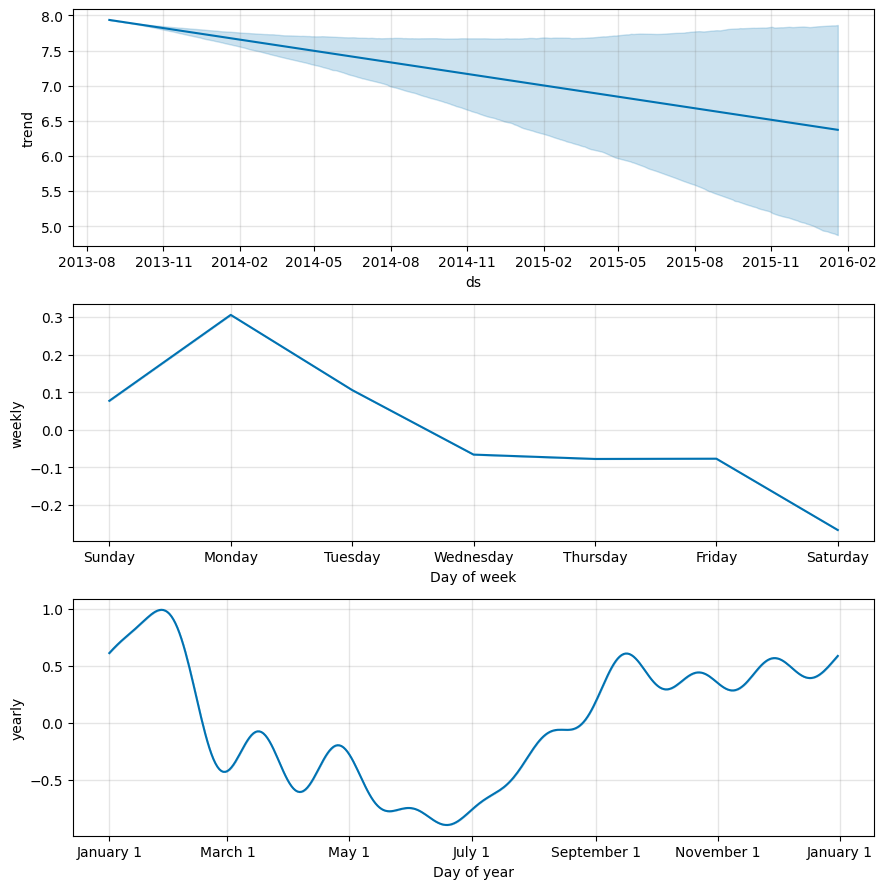

In [ ]:
# トレンドと季節性の分析

# コンポーネントの分解をプロット
fig2 = model.plot_components(forecast)
plt.show()

trend, weekly, yearlyの周期的な様子を見ることができます。
weeklyでは「月曜日が多く土曜日が少ない」、またyearlyを見ると1月が多い傾向が見られます。
アメリカンフットボール(NFL)試合日程は、通常のシーズンが9-12月にかけて行われ、一番盛り上がるプレーオフ、スーパボウルが1-2月にかけて行われるようです。そのため
Peyton ManningのWikipediaもそれに合わせて閲覧が増えるのかもしれません。

### <u>発展</u>
Prophetには、季節性の事前分布、影響度、変化点検出におけるデータ範囲、トレンドの影響など、調整可能なパラメータが多く存在します。Prophetではこれらのパラメータは自動で調整されるため気軽に将来予測を行うことができることが特徴なのですが、これらのパラメータは予測精度に大きな影響を与え、わずかな変更でも予測値が大きく変化することがあります。そのため、Prophetのパラメータチューニングは予測精度を高める上で重要であり、ここでは、**Optuna**を活用してその効果を検証します。

#### Optunaとは
ハイパーパラメータの自動チューニングを行うためのオープンソースライブラリです。機械学習モデルの性能を最大化するために、効率的に最適なハイパーパラメータを探索する機能を提供します。
特徴は、効率的な探索アルゴリズムです。
主にベイズ最適化に基づいた手法を採用しており、単純なランダム探索やグリッドサーチと比べて少ない試行回数で最適解を見つけやすいです。
特に、探索に効率的な「TPE（Tree-structured Parzen Estimator）」という手法を使っており、無駄を減らしながら重要な領域を重点的に探索します。

Optunaを使用してハイパーパラメータを最適化します。<br>
まずはライブラリをインストールします。

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.8 MB/s eta 0:00:00


まずは、パラメータの探索範囲をそれぞれ指定して、Optunaを実装します。<br>
今回は、以下の5つのパラメータチューニングを実施します。

1.   changepoint_prior_scale：トレンドの変化点に対する柔軟性を制御します
1.   seasonality_prior_scale：季節性の影響度を制御します
1.   n_changepoints：トレンドの変化点の数
1.   changepoint_range：トレンドの変化点を検知するのにどの範囲のデータを使用するかの割合
1.   holidays：特定イベントの影響を組み込みます（毎年のスーパーボウルの日付+1日を特定イベントとして設定）

目的関数（def objective）を設定し、その後、studyを用いて最適化を行います。ここでは、**RMSEを最小限に抑えることを目的**としています。

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore")

def objective(trial):
    # ハイパーパラメータの範囲設定
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.3)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10.0)
    n_changepoints = trial.suggest_int('n_changepoints', 20, 35)
    changepoint_range = trial.suggest_discrete_uniform('changepoint_range', 0.8, 0.95, 0.001)

    # 毎年のスーパーボウルの日付とその翌日にWikipediaページビュー数が上昇すると仮定して特定イベント日として設定する
    holidays = pd.DataFrame({
        'holiday': 'Superbowl',
        'ds': pd.to_datetime(['2008-02-03', '2009-02-01', '2010-02-07', '2011-02-06', '2012-02-05', '2013-02-03', '2014-02-02', '2015-02-01']),
        'lower_window': 0,
        'upper_window': 1
    })


    # Prophetモデルの設定
    model_op = Prophet(
        seasonality_mode='additive',
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        n_changepoints=n_changepoints,
        changepoint_range=changepoint_range,
        holidays=holidays
    )

    # モデルの学習
    model_op.fit(train_df)

    # テストデータに対する予測
    future = test_df[['ds']]
    forecast = model_op.predict(future)

    # 評価指標としてRMSEを最小化
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Optunaの最適化実行（再現性を持たせるためにseed固定）
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 最適なハイパーパラメータの表示
print("Best Parameters:", study.best_params)

[I 2025-02-12 00:40:59,658] A new study created in memory with name: no-name-ba8703ae-4b37-4f75-aa29-a9ee931faf50


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/wc1c25_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/3s3wzfsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35127', 'data', 'file=/tmp/tmpcfpvvmia/wc1c25_2.json', 'init=/tmp/tmpcfpvvmia/3s3wzfsg.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelzys6fbqv/prophet_model-20250212004100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcf

[I 2025-02-12 00:41:00,957] Trial 0 finished with value: 0.7208513875416614 and parameters: {'changepoint_prior_scale': 0.008468008575248327, 'seasonality_prior_scale': 7.114476009343421, 'n_changepoints': 31, 'changepoint_range': 0.89}. Best is trial 0 with value: 0.7208513875416614.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/cc1p90xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43884', 'data', 'file=/tmp/tmpcfpvvmia/xasko1jf.json', 'init=/tmp/tmpcfpvvmia/cc1p90xl.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model0p0ohyvf/prophet_model-20250212004101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_mz21eu3.json


[I 2025-02-12 00:41:01,952] Trial 1 finished with value: 0.5519758339849036 and parameters: {'changepoint_prior_scale': 0.0024348773534554596, 'seasonality_prior_scale': 0.029375384576328288, 'n_changepoints': 20, 'changepoint_range': 0.93}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/s46vr8sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20584', 'data', 'file=/tmp/tmpcfpvvmia/_mz21eu3.json', 'init=/tmp/tmpcfpvvmia/s46vr8sl.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelrq0awykr/prophet_model-20250212004102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/j2juguod.json


[I 2025-02-12 00:41:03,217] Trial 2 finished with value: 0.9761320111170225 and parameters: {'changepoint_prior_scale': 0.030834348179355788, 'seasonality_prior_scale': 1.3311216080736887, 'n_changepoints': 20, 'changepoint_range': 0.9460000000000001}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/0hmdbo2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94478', 'data', 'file=/tmp/tmpcfpvvmia/j2juguod.json', 'init=/tmp/tmpcfpvvmia/0hmdbo2i.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelq9kktz4_/prophet_model-20250212004103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/a0u1675c.json


[I 2025-02-12 00:41:05,128] Trial 3 finished with value: 0.9621038469169615 and parameters: {'changepoint_prior_scale': 0.11536162338241392, 'seasonality_prior_scale': 0.04335281794951567, 'n_changepoints': 22, 'changepoint_range': 0.8270000000000001}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/wmt66g2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45168', 'data', 'file=/tmp/tmpcfpvvmia/a0u1675c.json', 'init=/tmp/tmpcfpvvmia/wmt66g2q.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model9d6xu2q1/prophet_model-20250212004105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/002tc6ze.json


[I 2025-02-12 00:41:06,143] Trial 4 finished with value: 0.6016716314948793 and parameters: {'changepoint_prior_scale': 0.005670807781371429, 'seasonality_prior_scale': 0.3752055855124282, 'n_changepoints': 26, 'changepoint_range': 0.8430000000000001}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/wpnpi82w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73940', 'data', 'file=/tmp/tmpcfpvvmia/002tc6ze.json', 'init=/tmp/tmpcfpvvmia/wpnpi82w.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modellfpww26e/prophet_model-20250212004106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xr0_9se9.json


[I 2025-02-12 00:41:07,044] Trial 5 finished with value: 0.980694986495713 and parameters: {'changepoint_prior_scale': 0.032781876533976156, 'seasonality_prior_scale': 0.02621087878265441, 'n_changepoints': 24, 'changepoint_range': 0.8550000000000001}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/dthyiqyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50741', 'data', 'file=/tmp/tmpcfpvvmia/xr0_9se9.json', 'init=/tmp/tmpcfpvvmia/dthyiqyt.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelp5pndx8_/prophet_model-20250212004107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/h5i3ks4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/e3erqgp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

[I 2025-02-12 00:41:07,730] Trial 6 finished with value: 0.8330922295605339 and parameters: {'changepoint_prior_scale': 0.013481575603601416, 'seasonality_prior_scale': 2.267398652378039, 'n_changepoints': 23, 'changepoint_range': 0.877}. Best is trial 1 with value: 0.5519758339849036.


00:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/6jm8lvfe.json


[I 2025-02-12 00:41:08,698] Trial 7 finished with value: 0.9942908539973772 and parameters: {'changepoint_prior_scale': 0.029341527565000736, 'seasonality_prior_scale': 0.013783237455007183, 'n_changepoints': 29, 'changepoint_range': 0.8250000000000001}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/69h5ijwf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41408', 'data', 'file=/tmp/tmpcfpvvmia/6jm8lvfe.json', 'init=/tmp/tmpcfpvvmia/69h5ijwf.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model5cfcyc93/prophet_model-20250212004108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5hdmz_wz.json


[I 2025-02-12 00:41:09,704] Trial 8 finished with value: 0.8341353610249832 and parameters: {'changepoint_prior_scale': 0.0014492412389916862, 'seasonality_prior_scale': 7.025166339242156, 'n_changepoints': 35, 'changepoint_range': 0.922}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/n7q3vv_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13061', 'data', 'file=/tmp/tmpcfpvvmia/5hdmz_wz.json', 'init=/tmp/tmpcfpvvmia/n7q3vv_o.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelv2pww6i5/prophet_model-20250212004109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ec_cnqd8.json


[I 2025-02-12 00:41:10,706] Trial 9 finished with value: 0.6316521511067519 and parameters: {'changepoint_prior_scale': 0.0056828375585122656, 'seasonality_prior_scale': 0.019634341572933336, 'n_changepoints': 30, 'changepoint_range': 0.8660000000000001}. Best is trial 1 with value: 0.5519758339849036.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/lreen9r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73739', 'data', 'file=/tmp/tmpcfpvvmia/ec_cnqd8.json', 'init=/tmp/tmpcfpvvmia/lreen9r4.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model03_9qpvb/prophet_model-20250212004111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/pg60_19x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2wcn8xwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

[I 2025-02-12 00:41:11,328] Trial 10 finished with value: 0.9246660120937789 and parameters: {'changepoint_prior_scale': 0.0011314387991114068, 'seasonality_prior_scale': 0.12336245991553763, 'n_changepoints': 20, 'changepoint_range': 0.908}. Best is trial 1 with value: 0.5519758339849036.


00:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/b_6xrd9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/cec7peef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29393', 'data', 'file=/tmp/tmpcfpvvmia/b_6xrd9i.json', 'init=/tmp/tmpcfpvvmia/cec7peef.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model59cp995b/prophet_model-20250212004111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:11,829] Trial 11 finished with value: 0.5377078482384166 and parameters: {'changepoint_prior_scale': 0.0032314953989668097, 'seasonality_prior_scale': 0.36888121949571945, 'n_changepoints': 26, 'changepoint_range': 0.8450000000000001}. Best is trial 11 with value: 0.5377078482384166.


00:41:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2q2yg220.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xhpr9vjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55680', 'data', 'file=/tmp/tmpcfpvvmia/2q2yg220.json', 'init=/tmp/tmpcfpvvmia/xhpr9vjh.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelfzh1addd/prophet_model-20250212004112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:12,322] Trial 12 finished with value: 0.5516240682508993 and parameters: {'changepoint_prior_scale': 0.0026495983901894064, 'seasonality_prior_scale': 0.14243820286387338, 'n_changepoints': 26, 'changepoint_range': 0.804}. Best is trial 11 with value: 0.5377078482384166.


00:41:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/a964knb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/d7wgh3h1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70924', 'data', 'file=/tmp/tmpcfpvvmia/a964knb0.json', 'init=/tmp/tmpcfpvvmia/d7wgh3h1.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelhs0dbsyb/prophet_model-20250212004113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:12,911] Trial 13 finished with value: 0.5340091998600307 and parameters: {'changepoint_prior_scale': 0.0029964728017217875, 'seasonality_prior_scale': 0.21426028489725252, 'n_changepoints': 27, 'changepoint_range': 0.801}. Best is trial 13 with value: 0.5340091998600307.


00:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/13inph_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_rzzyp48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33335', 'data', 'file=/tmp/tmpcfpvvmia/13inph_o.json', 'init=/tmp/tmpcfpvvmia/_rzzyp48.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modell1cpgawy/prophet_model-20250212004113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:13,364] Trial 14 finished with value: 0.5672184873001452 and parameters: {'changepoint_prior_scale': 0.0024915682541726343, 'seasonality_prior_scale': 0.45296538230793765, 'n_changepoints': 27, 'changepoint_range': 0.8}. Best is trial 13 with value: 0.5340091998600307.


00:41:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jafkdg5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xe_34f7m.json


[I 2025-02-12 00:41:14,694] Trial 15 finished with value: 0.876897784878994 and parameters: {'changepoint_prior_scale': 0.1815215944359881, 'seasonality_prior_scale': 0.12124117775758486, 'n_changepoints': 32, 'changepoint_range': 0.8260000000000001}. Best is trial 13 with value: 0.5340091998600307.


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56772', 'data', 'file=/tmp/tmpcfpvvmia/jafkdg5i.json', 'init=/tmp/tmpcfpvvmia/xe_34f7m.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model9w5arj0p/prophet_model-20250212004114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/pvn_d2bo.json


[I 2025-02-12 00:41:15,380] Trial 16 finished with value: 0.6372120610145381 and parameters: {'changepoint_prior_scale': 0.005701456396677461, 'seasonality_prior_scale': 0.7656680572080377, 'n_changepoints': 28, 'changepoint_range': 0.8510000000000001}. Best is trial 13 with value: 0.5340091998600307.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/z13xazrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47122', 'data', 'file=/tmp/tmpcfpvvmia/pvn_d2bo.json', 'init=/tmp/tmpcfpvvmia/z13xazrg.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelp73105jy/prophet_model-20250212004115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/qzvw2c3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/570b0hi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

[I 2025-02-12 00:41:16,079] Trial 17 finished with value: 0.5323884512042816 and parameters: {'changepoint_prior_scale': 0.00327987759731418, 'seasonality_prior_scale': 0.21602375261639592, 'n_changepoints': 25, 'changepoint_range': 0.8140000000000001}. Best is trial 17 with value: 0.5323884512042816.


00:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/g5mkrj_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/s_15m7z1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19005', 'data', 'file=/tmp/tmpcfpvvmia/g5mkrj_7.json', 'init=/tmp/tmpcfpvvmia/s_15m7z1.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelu3y8nsp_/prophet_model-20250212004116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:16,558] Trial 18 finished with value: 0.8149524467288282 and parameters: {'changepoint_prior_scale': 0.011583319079939446, 'seasonality_prior_scale': 0.05936203045520165, 'n_changepoints': 24, 'changepoint_range': 0.8160000000000001}. Best is trial 17 with value: 0.5323884512042816.


00:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/lef4pad7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/p47wlgdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66080', 'data', 'file=/tmp/tmpcfpvvmia/lef4pad7.json', 'init=/tmp/tmpcfpvvmia/p47wlgdi.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modell43gf839/prophet_model-20250212004117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:17,210] Trial 19 finished with value: 0.9724392045576656 and parameters: {'changepoint_prior_scale': 0.06834832783533122, 'seasonality_prior_scale': 0.13860701098450776, 'n_changepoints': 33, 'changepoint_range': 0.8130000000000001}. Best is trial 17 with value: 0.5323884512042816.


00:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/gqs2z2yu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/l92kh5l2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58989', 'data', 'file=/tmp/tmpcfpvvmia/gqs2z2yu.json', 'init=/tmp/tmpcfpvvmia/l92kh5l2.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model4pqev5uc/prophet_model-20250212004117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:17,646] Trial 20 finished with value: 0.856616235868024 and parameters: {'changepoint_prior_scale': 0.0014949373491771494, 'seasonality_prior_scale': 1.9372544218502408, 'n_changepoints': 28, 'changepoint_range': 0.8300000000000001}. Best is trial 17 with value: 0.5323884512042816.


00:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/q_2x9tf3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/sc9yytxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25502', 'data', 'file=/tmp/tmpcfpvvmia/q_2x9tf3.json', 'init=/tmp/tmpcfpvvmia/sc9yytxv.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model55za9vek/prophet_model-20250212004118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:18,098] Trial 21 finished with value: 0.5298995303831725 and parameters: {'changepoint_prior_scale': 0.003304109287243755, 'seasonality_prior_scale': 0.26839127643943433, 'n_changepoints': 25, 'changepoint_range': 0.8}. Best is trial 21 with value: 0.5298995303831725.


00:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/3_4qtv82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/7evyyhrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28955', 'data', 'file=/tmp/tmpcfpvvmia/3_4qtv82.json', 'init=/tmp/tmpcfpvvmia/7evyyhrz.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelv0sldrr9/prophet_model-20250212004118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:18,693] Trial 22 finished with value: 0.5353349598286503 and parameters: {'changepoint_prior_scale': 0.00364830181795017, 'seasonality_prior_scale': 0.22500714633584018, 'n_changepoints': 25, 'changepoint_range': 0.808}. Best is trial 21 with value: 0.5298995303831725.


00:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/nhaj9564.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/pb56cu85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39958', 'data', 'file=/tmp/tmpcfpvvmia/nhaj9564.json', 'init=/tmp/tmpcfpvvmia/pb56cu85.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelsa0qupah/prophet_model-20250212004119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:19,139] Trial 23 finished with value: 0.6962291739675492 and parameters: {'changepoint_prior_scale': 0.007973174304969695, 'seasonality_prior_scale': 0.7696366748562349, 'n_changepoints': 23, 'changepoint_range': 0.8}. Best is trial 21 with value: 0.5298995303831725.


00:41:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xqsn6w6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/l0n2hjny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4628', 'data', 'file=/tmp/tmpcfpvvmia/xqsn6w6v.json', 'init=/tmp/tmpcfpvvmia/l0n2hjny.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelcu0dap6u/prophet_model-20250212004119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:19,596] Trial 24 finished with value: 0.9470294908660514 and parameters: {'changepoint_prior_scale': 0.0010055609901961009, 'seasonality_prior_scale': 0.07396793190860881, 'n_changepoints': 22, 'changepoint_range': 0.8370000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/47ej15z8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ksc2mlg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9249', 'data', 'file=/tmp/tmpcfpvvmia/47ej15z8.json', 'init=/tmp/tmpcfpvvmia/ksc2mlg_.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelhwh4xw45/prophet_model-20250212004120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:20,030] Trial 25 finished with value: 0.7316964574377023 and parameters: {'changepoint_prior_scale': 0.001752555139677302, 'seasonality_prior_scale': 0.21545195144248547, 'n_changepoints': 27, 'changepoint_range': 0.8160000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/rfi4yrbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/rqulnv20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61136', 'data', 'file=/tmp/tmpcfpvvmia/rfi4yrbp.json', 'init=/tmp/tmpcfpvvmia/rqulnv20.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelci0engt_/prophet_model-20250212004120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:20,463] Trial 26 finished with value: 0.8908193980840043 and parameters: {'changepoint_prior_scale': 0.015982723462920696, 'seasonality_prior_scale': 0.7786124943736366, 'n_changepoints': 25, 'changepoint_range': 0.8170000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5muo31c1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/rfc2m_wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5431', 'data', 'file=/tmp/tmpcfpvvmia/5muo31c1.json', 'init=/tmp/tmpcfpvvmia/rfc2m_wl.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model7guyiexn/prophet_model-20250212004121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:21 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-02-12 00:41:20,944] Trial 27 finished with value: 0.5372608996169114 and parameters: {'changepoint_prior_scale': 0.0037715834173097313, 'seasonality_prior_scale': 0.2472893680316495, 'n_changepoints': 29, 'changepoint_range': 0.869}. Best is trial 21 with value: 0.5298995303831725.


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/suom0lff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/no8pc2ax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65579', 'data', 'file=/tmp/tmpcfpvvmia/suom0lff.json', 'init=/tmp/tmpcfpvvmia/no8pc2ax.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelot7jo4ih/prophet_model-20250212004121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:21,351] Trial 28 finished with value: 0.5956167514000932 and parameters: {'changepoint_prior_scale': 0.004815319220621424, 'seasonality_prior_scale': 0.08210532698680609, 'n_changepoints': 25, 'changepoint_range': 0.8350000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ljwmjbti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/12dff52h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73781', 'data', 'file=/tmp/tmpcfpvvmia/ljwmjbti.json', 'init=/tmp/tmpcfpvvmia/12dff52h.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modeluvx6tlfs/prophet_model-20250212004122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:21,930] Trial 29 finished with value: 0.7095607173391563 and parameters: {'changepoint_prior_scale': 0.00909454579499986, 'seasonality_prior_scale': 0.5684583982782504, 'n_changepoints': 30, 'changepoint_range': 0.89}. Best is trial 21 with value: 0.5298995303831725.


00:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/f9hwwjuf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/7y3wljs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50875', 'data', 'file=/tmp/tmpcfpvvmia/f9hwwjuf.json', 'init=/tmp/tmpcfpvvmia/7y3wljs5.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modellj_l_9v_/prophet_model-20250212004122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:22,364] Trial 30 finished with value: 0.6854230401255789 and parameters: {'changepoint_prior_scale': 0.0019382076629282426, 'seasonality_prior_scale': 4.827075324648953, 'n_changepoints': 22, 'changepoint_range': 0.81}. Best is trial 21 with value: 0.5298995303831725.


00:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ba6rsdcw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xk_fpgu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91189', 'data', 'file=/tmp/tmpcfpvvmia/ba6rsdcw.json', 'init=/tmp/tmpcfpvvmia/xk_fpgu8.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelbrtupu2q/prophet_model-20250212004123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:22,885] Trial 31 finished with value: 0.5658734861278795 and parameters: {'changepoint_prior_scale': 0.004672028286783672, 'seasonality_prior_scale': 0.22614157648824498, 'n_changepoints': 25, 'changepoint_range': 0.808}. Best is trial 21 with value: 0.5298995303831725.


00:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5qroscfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/c17egyip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77152', 'data', 'file=/tmp/tmpcfpvvmia/5qroscfz.json', 'init=/tmp/tmpcfpvvmia/c17egyip.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model18bfe1hh/prophet_model-20250212004123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:23,368] Trial 32 finished with value: 0.5314196159278621 and parameters: {'changepoint_prior_scale': 0.0035201847379492477, 'seasonality_prior_scale': 0.2030935117616899, 'n_changepoints': 27, 'changepoint_range': 0.8190000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/29qhjive.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jemhfgz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42645', 'data', 'file=/tmp/tmpcfpvvmia/29qhjive.json', 'init=/tmp/tmpcfpvvmia/jemhfgz5.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modell81qn06z/prophet_model-20250212004123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:23,825] Trial 33 finished with value: 0.7206574469518631 and parameters: {'changepoint_prior_scale': 0.008080576913461233, 'seasonality_prior_scale': 1.233137449550122, 'n_changepoints': 27, 'changepoint_range': 0.8200000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/4b8vg3hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_el_cszy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14083', 'data', 'file=/tmp/tmpcfpvvmia/4b8vg3hg.json', 'init=/tmp/tmpcfpvvmia/_el_cszy.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelr32biedi/prophet_model-20250212004124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:24,372] Trial 34 finished with value: 0.5772583830310504 and parameters: {'changepoint_prior_scale': 0.0022067338987614626, 'seasonality_prior_scale': 0.18294206405906913, 'n_changepoints': 29, 'changepoint_range': 0.8}. Best is trial 21 with value: 0.5298995303831725.


00:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2mg8q2qt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/f_tju0iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58048', 'data', 'file=/tmp/tmpcfpvvmia/2mg8q2qt.json', 'init=/tmp/tmpcfpvvmia/f_tju0iw.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelumwv2zmj/prophet_model-20250212004125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:24,901] Trial 35 finished with value: 0.5321559961081254 and parameters: {'changepoint_prior_scale': 0.003110721572673311, 'seasonality_prior_scale': 0.04385285395855093, 'n_changepoints': 24, 'changepoint_range': 0.8360000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/u826d4e9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/zjftjwm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76133', 'data', 'file=/tmp/tmpcfpvvmia/u826d4e9.json', 'init=/tmp/tmpcfpvvmia/zjftjwm5.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelodzmd8n4/prophet_model-20250212004125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:25,467] Trial 36 finished with value: 0.9087034712498394 and parameters: {'changepoint_prior_scale': 0.020690839036154478, 'seasonality_prior_scale': 0.040613942131060184, 'n_changepoints': 21, 'changepoint_range': 0.8380000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/tuazgnqb.json


[I 2025-02-12 00:41:25,942] Trial 37 finished with value: 0.651187520998008 and parameters: {'changepoint_prior_scale': 0.006920431564094447, 'seasonality_prior_scale': 0.04332176593908249, 'n_changepoints': 24, 'changepoint_range': 0.8570000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/sn5_7x__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60011', 'data', 'file=/tmp/tmpcfpvvmia/tuazgnqb.json', 'init=/tmp/tmpcfpvvmia/sn5_7x__.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelxsrmac3l/prophet_model-20250212004126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/6gyskda0.json


[I 2025-02-12 00:41:26,523] Trial 38 finished with value: 0.5314151101062582 and parameters: {'changepoint_prior_scale': 0.003769100061926003, 'seasonality_prior_scale': 0.088914223911732, 'n_changepoints': 23, 'changepoint_range': 0.95}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jrrptdxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25710', 'data', 'file=/tmp/tmpcfpvvmia/6gyskda0.json', 'init=/tmp/tmpcfpvvmia/jrrptdxx.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelx1cezprf/prophet_model-20250212004126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jhn5t5nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/4l3zvf3v.json
DEBUG:cmdstanpy:idx 0


[I 2025-02-12 00:41:27,239] Trial 39 finished with value: 0.7748868202128867 and parameters: {'changepoint_prior_scale': 0.010154685403585868, 'seasonality_prior_scale': 0.027138063663410972, 'n_changepoints': 23, 'changepoint_range': 0.936}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80680', 'data', 'file=/tmp/tmpcfpvvmia/jhn5t5nn.json', 'init=/tmp/tmpcfpvvmia/4l3zvf3v.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model9qp3e_8m/prophet_model-20250212004127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/4jgu5yv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/f3t1nsl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/

[I 2025-02-12 00:41:28,132] Trial 40 finished with value: 0.9692049662772867 and parameters: {'changepoint_prior_scale': 0.2987934767801677, 'seasonality_prior_scale': 0.010983569257956205, 'n_changepoints': 21, 'changepoint_range': 0.909}. Best is trial 21 with value: 0.5298995303831725.


00:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/30y4a4ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/q9zn0stu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1400', 'data', 'file=/tmp/tmpcfpvvmia/30y4a4ff.json', 'init=/tmp/tmpcfpvvmia/q9zn0stu.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelj963rret/prophet_model-20250212004128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:28,585] Trial 41 finished with value: 0.5501087853261543 and parameters: {'changepoint_prior_scale': 0.004267445450894681, 'seasonality_prior_scale': 0.08150072876791324, 'n_changepoints': 24, 'changepoint_range': 0.95}. Best is trial 21 with value: 0.5298995303831725.


00:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/fpjqfaq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/vktg5l6j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94280', 'data', 'file=/tmp/tmpcfpvvmia/fpjqfaq4.json', 'init=/tmp/tmpcfpvvmia/vktg5l6j.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelrx9f3kpc/prophet_model-20250212004129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:29,110] Trial 42 finished with value: 0.6242894544109714 and parameters: {'changepoint_prior_scale': 0.002194825960124247, 'seasonality_prior_scale': 0.32646755426903007, 'n_changepoints': 26, 'changepoint_range': 0.8220000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/evoh_tg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/vevmckwh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71956', 'data', 'file=/tmp/tmpcfpvvmia/evoh_tg7.json', 'init=/tmp/tmpcfpvvmia/vevmckwh.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model_l2r8n9d/prophet_model-20250212004129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:29,550] Trial 43 finished with value: 0.8707157842892856 and parameters: {'changepoint_prior_scale': 0.0013272283750603068, 'seasonality_prior_scale': 0.09410928784616278, 'n_changepoints': 23, 'changepoint_range': 0.88}. Best is trial 21 with value: 0.5298995303831725.


00:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5609hw93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/0nb5da14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74708', 'data', 'file=/tmp/tmpcfpvvmia/5609hw93.json', 'init=/tmp/tmpcfpvvmia/0nb5da14.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelvw_1x2et/prophet_model-20250212004130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:30,016] Trial 44 finished with value: 0.530941641785661 and parameters: {'changepoint_prior_scale': 0.0030361786307884714, 'seasonality_prior_scale': 0.05826232904528474, 'n_changepoints': 24, 'changepoint_range': 0.8290000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_zhcob3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/4c1kzbi1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33482', 'data', 'file=/tmp/tmpcfpvvmia/_zhcob3k.json', 'init=/tmp/tmpcfpvvmia/4c1kzbi1.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelug02prrs/prophet_model-20250212004130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:30,475] Trial 45 finished with value: 0.633107586132523 and parameters: {'changepoint_prior_scale': 0.005895207110564572, 'seasonality_prior_scale': 0.05776321606530002, 'n_changepoints': 22, 'changepoint_range': 0.8490000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/edsetiir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/n3gpmx1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46584', 'data', 'file=/tmp/tmpcfpvvmia/edsetiir.json', 'init=/tmp/tmpcfpvvmia/n3gpmx1l.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelykgzz4c5/prophet_model-20250212004131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:31,081] Trial 46 finished with value: 1.0242511957944862 and parameters: {'changepoint_prior_scale': 0.0528961962856459, 'seasonality_prior_scale': 0.015425638455359336, 'n_changepoints': 24, 'changepoint_range': 0.8620000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/gth4hlkg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/8_g52avs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61976', 'data', 'file=/tmp/tmpcfpvvmia/gth4hlkg.json', 'init=/tmp/tmpcfpvvmia/8_g52avs.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelr75bt3e9/prophet_model-20250212004131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:31,576] Trial 47 finished with value: 0.5488785439998155 and parameters: {'changepoint_prior_scale': 0.0026622650253435797, 'seasonality_prior_scale': 0.030570343235883268, 'n_changepoints': 21, 'changepoint_range': 0.8300000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/qkrlzv74.json


[I 2025-02-12 00:41:32,118] Trial 48 finished with value: 0.6144077017022024 and parameters: {'changepoint_prior_scale': 0.0018405679936012432, 'seasonality_prior_scale': 0.019427294011185592, 'n_changepoints': 26, 'changepoint_range': 0.918}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/3af3lik9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26539', 'data', 'file=/tmp/tmpcfpvvmia/qkrlzv74.json', 'init=/tmp/tmpcfpvvmia/3af3lik9.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelkad05p92/prophet_model-20250212004132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/b0jgsube.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/he04bp6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

[I 2025-02-12 00:41:32,736] Trial 49 finished with value: 0.559504313538489 and parameters: {'changepoint_prior_scale': 0.00439880962896032, 'seasonality_prior_scale': 0.11029181423968992, 'n_changepoints': 23, 'changepoint_range': 0.9}. Best is trial 21 with value: 0.5298995303831725.


00:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/whr343z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/js0ltekq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95429', 'data', 'file=/tmp/tmpcfpvvmia/whr343z5.json', 'init=/tmp/tmpcfpvvmia/js0ltekq.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelsayp9ezx/prophet_model-20250212004133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:33,212] Trial 50 finished with value: 0.5321494172502551 and parameters: {'changepoint_prior_scale': 0.0029356876265515266, 'seasonality_prior_scale': 0.05815180584960207, 'n_changepoints': 24, 'changepoint_range': 0.8460000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/3p_v5tmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/09c5lqeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91577', 'data', 'file=/tmp/tmpcfpvvmia/3p_v5tmx.json', 'init=/tmp/tmpcfpvvmia/09c5lqeh.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelr702o7yj/prophet_model-20250212004133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:33,705] Trial 51 finished with value: 0.5330883629995735 and parameters: {'changepoint_prior_scale': 0.0030724175748619684, 'seasonality_prior_scale': 0.056543603693017884, 'n_changepoints': 24, 'changepoint_range': 0.8420000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/p0aoeen2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/840tg6b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65467', 'data', 'file=/tmp/tmpcfpvvmia/p0aoeen2.json', 'init=/tmp/tmpcfpvvmia/840tg6b4.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelmos72gd3/prophet_model-20250212004134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:34,208] Trial 52 finished with value: 0.5436168587370269 and parameters: {'changepoint_prior_scale': 0.002707994215576567, 'seasonality_prior_scale': 0.036165111200328136, 'n_changepoints': 26, 'changepoint_range': 0.8300000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/citti8nv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/tyd7b2r4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6353', 'data', 'file=/tmp/tmpcfpvvmia/citti8nv.json', 'init=/tmp/tmpcfpvvmia/tyd7b2r4.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model33yrz4cr/prophet_model-20250212004134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:34,680] Trial 53 finished with value: 0.8893553521461135 and parameters: {'changepoint_prior_scale': 0.0013431908841173542, 'seasonality_prior_scale': 0.05921037944581447, 'n_changepoints': 25, 'changepoint_range': 0.8470000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_elnn4ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jmus_5d1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95625', 'data', 'file=/tmp/tmpcfpvvmia/_elnn4ef.json', 'init=/tmp/tmpcfpvvmia/jmus_5d1.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model27sn0_ef/prophet_model-20250212004135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:35,156] Trial 54 finished with value: 0.6715287491170808 and parameters: {'changepoint_prior_scale': 0.007037443633663339, 'seasonality_prior_scale': 0.1679192650438224, 'n_changepoints': 23, 'changepoint_range': 0.8540000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/6g530h6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/cuk53y7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19078', 'data', 'file=/tmp/tmpcfpvvmia/6g530h6y.json', 'init=/tmp/tmpcfpvvmia/cuk53y7c.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelze7rae0p/prophet_model-20250212004135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:35,647] Trial 55 finished with value: 0.5525494398299434 and parameters: {'changepoint_prior_scale': 0.00361484794083457, 'seasonality_prior_scale': 0.10684183112972294, 'n_changepoints': 24, 'changepoint_range': 0.8230000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/73mmgbj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/maqz2y2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99825', 'data', 'file=/tmp/tmpcfpvvmia/73mmgbj2.json', 'init=/tmp/tmpcfpvvmia/maqz2y2q.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelaqazpb5v/prophet_model-20250212004136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:36,102] Trial 56 finished with value: 0.608968839504872 and parameters: {'changepoint_prior_scale': 0.005539547340670253, 'seasonality_prior_scale': 0.02081727846817731, 'n_changepoints': 22, 'changepoint_range': 0.933}. Best is trial 21 with value: 0.5298995303831725.


00:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/4t12y0jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/usud1stk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3982', 'data', 'file=/tmp/tmpcfpvvmia/4t12y0jv.json', 'init=/tmp/tmpcfpvvmia/usud1stk.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model010t4ovw/prophet_model-20250212004136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:36,554] Trial 57 finished with value: 0.7218325607255955 and parameters: {'changepoint_prior_scale': 0.0016850811421175267, 'seasonality_prior_scale': 0.44102035682051705, 'n_changepoints': 28, 'changepoint_range': 0.8410000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/sgxg1rpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/uzjyv3mf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40790', 'data', 'file=/tmp/tmpcfpvvmia/sgxg1rpv.json', 'init=/tmp/tmpcfpvvmia/uzjyv3mf.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelcxhept3r/prophet_model-20250212004137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:37,061] Trial 58 finished with value: 0.5709972101306887 and parameters: {'changepoint_prior_scale': 0.002229214743420061, 'seasonality_prior_scale': 0.15951446564905727, 'n_changepoints': 35, 'changepoint_range': 0.8320000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_2z6wt8f.json


[I 2025-02-12 00:41:37,549] Trial 59 finished with value: 0.5328028541797888 and parameters: {'changepoint_prior_scale': 0.003335783167448913, 'seasonality_prior_scale': 0.3065609820838618, 'n_changepoints': 25, 'changepoint_range': 0.806}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/sb9jxwkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86533', 'data', 'file=/tmp/tmpcfpvvmia/_2z6wt8f.json', 'init=/tmp/tmpcfpvvmia/sb9jxwkp.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelk6r07bmj/prophet_model-20250212004137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/8v0yzivj.json


[I 2025-02-12 00:41:38,286] Trial 60 finished with value: 0.8501688857868506 and parameters: {'changepoint_prior_scale': 0.012317645573280583, 'seasonality_prior_scale': 0.06655748451969869, 'n_changepoints': 26, 'changepoint_range': 0.881}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/fi_54e9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1231', 'data', 'file=/tmp/tmpcfpvvmia/8v0yzivj.json', 'init=/tmp/tmpcfpvvmia/fi_54e9a.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model1yneaeut/prophet_model-20250212004138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_6bjh020.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xwkks4tf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

[I 2025-02-12 00:41:38,945] Trial 61 finished with value: 0.5327403431081194 and parameters: {'changepoint_prior_scale': 0.0030140164301036805, 'seasonality_prior_scale': 0.04990203107683122, 'n_changepoints': 24, 'changepoint_range': 0.812}. Best is trial 21 with value: 0.5298995303831725.


00:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5peh01qr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/zz6ts6x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57043', 'data', 'file=/tmp/tmpcfpvvmia/5peh01qr.json', 'init=/tmp/tmpcfpvvmia/zz6ts6x9.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model3qccy8a1/prophet_model-20250212004139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:39,465] Trial 62 finished with value: 0.5692801352455079 and parameters: {'changepoint_prior_scale': 0.003997083385778164, 'seasonality_prior_scale': 0.1369973459855124, 'n_changepoints': 25, 'changepoint_range': 0.8250000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/nt3lrgoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/bqyrsufq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9406', 'data', 'file=/tmp/tmpcfpvvmia/nt3lrgoq.json', 'init=/tmp/tmpcfpvvmia/bqyrsufq.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modellep01rcb/prophet_model-20250212004140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:39,946] Trial 63 finished with value: 0.6012576570456647 and parameters: {'changepoint_prior_scale': 0.005258884467176346, 'seasonality_prior_scale': 0.2989670223087856, 'n_changepoints': 26, 'changepoint_range': 0.8170000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/u9acaayg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/dwyaazvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6306', 'data', 'file=/tmp/tmpcfpvvmia/u9acaayg.json', 'init=/tmp/tmpcfpvvmia/dwyaazvv.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelzkz3lwp4/prophet_model-20250212004140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:40,473] Trial 64 finished with value: 0.5550284443876712 and parameters: {'changepoint_prior_scale': 0.0024626439486632313, 'seasonality_prior_scale': 0.09406687878788582, 'n_changepoints': 25, 'changepoint_range': 0.8350000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ofm0tzlu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/o916ux9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89602', 'data', 'file=/tmp/tmpcfpvvmia/ofm0tzlu.json', 'init=/tmp/tmpcfpvvmia/o916ux9m.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model0yt5a20o/prophet_model-20250212004141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:40,936] Trial 65 finished with value: 0.6502608381249946 and parameters: {'changepoint_prior_scale': 0.00649562859662701, 'seasonality_prior_scale': 0.5839488027400296, 'n_changepoints': 27, 'changepoint_range': 0.8130000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/vvo7d5gv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/53vzyti1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70463', 'data', 'file=/tmp/tmpcfpvvmia/vvo7d5gv.json', 'init=/tmp/tmpcfpvvmia/53vzyti1.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelko_h_mdf/prophet_model-20250212004141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:41,381] Trial 66 finished with value: 0.8160582365627786 and parameters: {'changepoint_prior_scale': 0.0015794333549333734, 'seasonality_prior_scale': 0.07750034043418562, 'n_changepoints': 23, 'changepoint_range': 0.805}. Best is trial 21 with value: 0.5298995303831725.


00:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/d7afdqol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/m333u6xz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24055', 'data', 'file=/tmp/tmpcfpvvmia/d7afdqol.json', 'init=/tmp/tmpcfpvvmia/m333u6xz.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelvd3n6r8v/prophet_model-20250212004142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:41,885] Trial 67 finished with value: 0.5305922873859613 and parameters: {'changepoint_prior_scale': 0.0033831126892493756, 'seasonality_prior_scale': 0.19054879926156343, 'n_changepoints': 24, 'changepoint_range': 0.8190000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/qgy5n2hw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/s4xs0e39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42217', 'data', 'file=/tmp/tmpcfpvvmia/qgy5n2hw.json', 'init=/tmp/tmpcfpvvmia/s4xs0e39.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelvn7p_jhk/prophet_model-20250212004142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:42,342] Trial 68 finished with value: 0.9789477355952025 and parameters: {'changepoint_prior_scale': 0.0011994694270140755, 'seasonality_prior_scale': 0.037383756800465684, 'n_changepoints': 23, 'changepoint_range': 0.8260000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/hl_gzrfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/b07sljci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73083', 'data', 'file=/tmp/tmpcfpvvmia/hl_gzrfz.json', 'init=/tmp/tmpcfpvvmia/b07sljci.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modello1mhzbt/prophet_model-20250212004142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:42,818] Trial 69 finished with value: 0.6453842240330563 and parameters: {'changepoint_prior_scale': 0.0019492518497427201, 'seasonality_prior_scale': 0.17685725505271654, 'n_changepoints': 22, 'changepoint_range': 0.8440000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/hj2kcmjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/7k5etku2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88074', 'data', 'file=/tmp/tmpcfpvvmia/hj2kcmjl.json', 'init=/tmp/tmpcfpvvmia/7k5etku2.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelvz_c351q/prophet_model-20250212004143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:43,337] Trial 70 finished with value: 0.5353031180436434 and parameters: {'changepoint_prior_scale': 0.0037412585243010495, 'seasonality_prior_scale': 0.12582894304967537, 'n_changepoints': 24, 'changepoint_range': 0.8210000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/hhmyqoox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/tf77xcva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93464', 'data', 'file=/tmp/tmpcfpvvmia/hhmyqoox.json', 'init=/tmp/tmpcfpvvmia/tf77xcva.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modeltgfm33ul/prophet_model-20250212004143.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:43,812] Trial 71 finished with value: 0.5300365681849548 and parameters: {'changepoint_prior_scale': 0.003037035749027321, 'seasonality_prior_scale': 0.25781558543005556, 'n_changepoints': 24, 'changepoint_range': 0.8180000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/fmn255yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/j7cltg75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5779', 'data', 'file=/tmp/tmpcfpvvmia/fmn255yr.json', 'init=/tmp/tmpcfpvvmia/j7cltg75.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelcml0n0sb/prophet_model-20250212004144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:44,399] Trial 72 finished with value: 0.5547502078111992 and parameters: {'changepoint_prior_scale': 0.0026363217512824677, 'seasonality_prior_scale': 0.24502295023467185, 'n_changepoints': 24, 'changepoint_range': 0.8330000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/6mrvmt6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/m0szeyos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87817', 'data', 'file=/tmp/tmpcfpvvmia/6mrvmt6p.json', 'init=/tmp/tmpcfpvvmia/m0szeyos.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model6xkyisjd/prophet_model-20250212004145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:44,871] Trial 73 finished with value: 0.5963929335872329 and parameters: {'changepoint_prior_scale': 0.004726798203136476, 'seasonality_prior_scale': 0.045879395010509, 'n_changepoints': 34, 'changepoint_range': 0.8180000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/kl8rw18g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2ggerldg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97756', 'data', 'file=/tmp/tmpcfpvvmia/kl8rw18g.json', 'init=/tmp/tmpcfpvvmia/2ggerldg.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model24hnjmji/prophet_model-20250212004145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:45,363] Trial 74 finished with value: 0.530242546090581 and parameters: {'changepoint_prior_scale': 0.003292478914156005, 'seasonality_prior_scale': 0.41165526593750584, 'n_changepoints': 23, 'changepoint_range': 0.8270000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2yjjjhb6.json


[I 2025-02-12 00:41:45,873] Trial 75 finished with value: 0.5347831956264155 and parameters: {'changepoint_prior_scale': 0.003826008982208354, 'seasonality_prior_scale': 0.4593968000530867, 'n_changepoints': 21, 'changepoint_range': 0.8280000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ldr_u866.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30877', 'data', 'file=/tmp/tmpcfpvvmia/2yjjjhb6.json', 'init=/tmp/tmpcfpvvmia/ldr_u866.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelv7_7ubi7/prophet_model-20250212004146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xbg3rexr.json


[I 2025-02-12 00:41:46,713] Trial 76 finished with value: 0.6115754151393608 and parameters: {'changepoint_prior_scale': 0.002083871342031223, 'seasonality_prior_scale': 0.2683519664357471, 'n_changepoints': 22, 'changepoint_range': 0.81}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/o1sf81er.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48556', 'data', 'file=/tmp/tmpcfpvvmia/xbg3rexr.json', 'init=/tmp/tmpcfpvvmia/o1sf81er.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelqls0kh55/prophet_model-20250212004146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/os5kous4.json


[I 2025-02-12 00:41:47,557] Trial 77 finished with value: 0.6010036239887573 and parameters: {'changepoint_prior_scale': 0.0049336751009064345, 'seasonality_prior_scale': 0.5993196078789126, 'n_changepoints': 20, 'changepoint_range': 0.802}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/6uxzshuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65314', 'data', 'file=/tmp/tmpcfpvvmia/os5kous4.json', 'init=/tmp/tmpcfpvvmia/6uxzshuu.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelegstv5a7/prophet_model-20250212004147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jzu1ynu4.json


[I 2025-02-12 00:41:48,411] Trial 78 finished with value: 0.53241222132402 and parameters: {'changepoint_prior_scale': 0.0028340041000797286, 'seasonality_prior_scale': 0.3728375319624893, 'n_changepoints': 23, 'changepoint_range': 0.8390000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/g9g1spq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6721', 'data', 'file=/tmp/tmpcfpvvmia/jzu1ynu4.json', 'init=/tmp/tmpcfpvvmia/g9g1spq_.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelhamotctn/prophet_model-20250212004148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[I 2025-02-12 00:41:49,558] Trial 79 finished with value: 0.9421743150499321 and parameters: {'changepoint_prior_scale': 0.022686309338924907, 'seasonality_prior_scale': 1.060261648146427, 'n_changepoints': 25, 'changepoint_range': 0.8720000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/go49283x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/m4fdchbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84393', 'data', 'file=/tmp/tmpcfpvvmia/go49283x.json', 'init=/tmp/tmpcfpvvmia/m4fdchbh.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model1r61jcvv/prophet_model-20250212004150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5n65u6va.json


[I 2025-02-12 00:41:51,359] Trial 80 finished with value: 0.5808828583727055 and parameters: {'changepoint_prior_scale': 0.0023793547743950995, 'seasonality_prior_scale': 0.43618880724611725, 'n_changepoints': 30, 'changepoint_range': 0.8190000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ccsm_hwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30992', 'data', 'file=/tmp/tmpcfpvvmia/5n65u6va.json', 'init=/tmp/tmpcfpvvmia/ccsm_hwb.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model9_wrhk57/prophet_model-20250212004151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ato60pri.json


[I 2025-02-12 00:41:52,106] Trial 81 finished with value: 0.5335898925141606 and parameters: {'changepoint_prior_scale': 0.003165587721648454, 'seasonality_prior_scale': 0.19057098861821106, 'n_changepoints': 24, 'changepoint_range': 0.8240000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/nt461vya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69426', 'data', 'file=/tmp/tmpcfpvvmia/ato60pri.json', 'init=/tmp/tmpcfpvvmia/nt461vya.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modellogzoyf0/prophet_model-20250212004152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ysnnqkbu.json


[I 2025-02-12 00:41:53,029] Trial 82 finished with value: 0.53089107315905 and parameters: {'changepoint_prior_scale': 0.0033598197626810273, 'seasonality_prior_scale': 0.14393432239935194, 'n_changepoints': 23, 'changepoint_range': 0.8360000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/i0po6gqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64656', 'data', 'file=/tmp/tmpcfpvvmia/ysnnqkbu.json', 'init=/tmp/tmpcfpvvmia/i0po6gqg.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model6y1so8x6/prophet_model-20250212004153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/m763y6du.json


[I 2025-02-12 00:41:53,892] Trial 83 finished with value: 0.5402603555132678 and parameters: {'changepoint_prior_scale': 0.004187316441111162, 'seasonality_prior_scale': 0.15360226048205894, 'n_changepoints': 23, 'changepoint_range': 0.8280000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/o3c5hhc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54964', 'data', 'file=/tmp/tmpcfpvvmia/m763y6du.json', 'init=/tmp/tmpcfpvvmia/o3c5hhc3.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modely9issh_h/prophet_model-20250212004154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2ues2qke.json


[I 2025-02-12 00:41:54,873] Trial 84 finished with value: 0.5310770150157186 and parameters: {'changepoint_prior_scale': 0.0033674082027900327, 'seasonality_prior_scale': 0.20348811644178783, 'n_changepoints': 23, 'changepoint_range': 0.9400000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/hf0vp1jv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95853', 'data', 'file=/tmp/tmpcfpvvmia/2ues2qke.json', 'init=/tmp/tmpcfpvvmia/hf0vp1jv.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelk6chh100/prophet_model-20250212004155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ih3hosr5.json


[I 2025-02-12 00:41:55,575] Trial 85 finished with value: 0.6337707434128285 and parameters: {'changepoint_prior_scale': 0.006309055630547654, 'seasonality_prior_scale': 0.21094190376714664, 'n_changepoints': 22, 'changepoint_range': 0.95}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5pvyiy17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82972', 'data', 'file=/tmp/tmpcfpvvmia/ih3hosr5.json', 'init=/tmp/tmpcfpvvmia/5pvyiy17.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model6kxda5vo/prophet_model-20250212004155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/2hy3et3m.json


[I 2025-02-12 00:41:56,369] Trial 86 finished with value: 0.5307097012812947 and parameters: {'changepoint_prior_scale': 0.003504772927993472, 'seasonality_prior_scale': 0.3371985736515571, 'n_changepoints': 23, 'changepoint_range': 0.9400000000000001}. Best is trial 21 with value: 0.5298995303831725.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/1b3hq5mz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29187', 'data', 'file=/tmp/tmpcfpvvmia/2hy3et3m.json', 'init=/tmp/tmpcfpvvmia/1b3hq5mz.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model47hl8ypv/prophet_model-20250212004156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_h75z8ll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/_of4eo_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

[I 2025-02-12 00:41:57,036] Trial 87 finished with value: 0.7409611989992226 and parameters: {'changepoint_prior_scale': 0.009655452831088958, 'seasonality_prior_scale': 0.34223412139287146, 'n_changepoints': 23, 'changepoint_range': 0.9420000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/j890hqws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/bjky875q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79134', 'data', 'file=/tmp/tmpcfpvvmia/j890hqws.json', 'init=/tmp/tmpcfpvvmia/bjky875q.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelk2lisyv3/prophet_model-20250212004157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:57,462] Trial 88 finished with value: 0.553307384775913 and parameters: {'changepoint_prior_scale': 0.004353993178124665, 'seasonality_prior_scale': 0.10346016771202808, 'n_changepoints': 23, 'changepoint_range': 0.937}. Best is trial 21 with value: 0.5298995303831725.


00:41:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/zqps30gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/7y42g13e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72179', 'data', 'file=/tmp/tmpcfpvvmia/zqps30gn.json', 'init=/tmp/tmpcfpvvmia/7y42g13e.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelybz4p69p/prophet_model-20250212004158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:57,934] Trial 89 finished with value: 0.5308620116890951 and parameters: {'changepoint_prior_scale': 0.0034708171731441906, 'seasonality_prior_scale': 0.2874703064022502, 'n_changepoints': 21, 'changepoint_range': 0.925}. Best is trial 21 with value: 0.5298995303831725.


00:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/hls7es3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/s6sddl5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92690', 'data', 'file=/tmp/tmpcfpvvmia/hls7es3i.json', 'init=/tmp/tmpcfpvvmia/s6sddl5i.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model6fmq_zs1/prophet_model-20250212004158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:58,445] Trial 90 finished with value: 0.6813495087334902 and parameters: {'changepoint_prior_scale': 0.007544048296060771, 'seasonality_prior_scale': 0.27161715414846627, 'n_changepoints': 21, 'changepoint_range': 0.92}. Best is trial 21 with value: 0.5298995303831725.


00:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/d4qa3pr4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/tcsuh31y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30909', 'data', 'file=/tmp/tmpcfpvvmia/d4qa3pr4.json', 'init=/tmp/tmpcfpvvmia/tcsuh31y.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelln87l403/prophet_model-20250212004159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:58,904] Trial 91 finished with value: 0.5301028049591617 and parameters: {'changepoint_prior_scale': 0.0033957758597723407, 'seasonality_prior_scale': 0.5030001329039199, 'n_changepoints': 22, 'changepoint_range': 0.926}. Best is trial 21 with value: 0.5298995303831725.


00:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/7uyeeqq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/lhws7e5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58066', 'data', 'file=/tmp/tmpcfpvvmia/7uyeeqq6.json', 'init=/tmp/tmpcfpvvmia/lhws7e5v.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model1oyl9s3i/prophet_model-20250212004159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:59,396] Trial 92 finished with value: 0.5722926641950161 and parameters: {'changepoint_prior_scale': 0.002460328503047486, 'seasonality_prior_scale': 0.6870951784619507, 'n_changepoints': 20, 'changepoint_range': 0.9430000000000001}. Best is trial 21 with value: 0.5298995303831725.


00:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jlxi174w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/btib_nss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65550', 'data', 'file=/tmp/tmpcfpvvmia/jlxi174w.json', 'init=/tmp/tmpcfpvvmia/btib_nss.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model30spm6hh/prophet_model-20250212004200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:41:59,915] Trial 93 finished with value: 0.5298459047178414 and parameters: {'changepoint_prior_scale': 0.003527842155980803, 'seasonality_prior_scale': 0.3927020963528198, 'n_changepoints': 22, 'changepoint_range': 0.915}. Best is trial 93 with value: 0.5298459047178414.


00:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/5wcxrkef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/bj24lj7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58268', 'data', 'file=/tmp/tmpcfpvvmia/5wcxrkef.json', 'init=/tmp/tmpcfpvvmia/bj24lj7b.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modell_zns9mk/prophet_model-20250212004200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:42:00,352] Trial 94 finished with value: 0.5962406899441376 and parameters: {'changepoint_prior_scale': 0.005376246034786308, 'seasonality_prior_scale': 0.5155310078695521, 'n_changepoints': 21, 'changepoint_range': 0.925}. Best is trial 93 with value: 0.5298459047178414.


00:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/xeqwyu37.json


[I 2025-02-12 00:42:00,824] Trial 95 finished with value: 0.7012829156011039 and parameters: {'changepoint_prior_scale': 0.00197298823363136, 'seasonality_prior_scale': 0.390574537223664, 'n_changepoints': 22, 'changepoint_range': 0.91}. Best is trial 93 with value: 0.5298459047178414.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/dpnrtqxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57924', 'data', 'file=/tmp/tmpcfpvvmia/xeqwyu37.json', 'init=/tmp/tmpcfpvvmia/dpnrtqxl.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model8pzkaimi/prophet_model-20250212004201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/m4barizl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/94qj72k_.json
DEBUG:cmdstanpy:idx 0


[I 2025-02-12 00:42:01,446] Trial 96 finished with value: 0.5321101052570366 and parameters: {'changepoint_prior_scale': 0.0034740491049332764, 'seasonality_prior_scale': 0.9104436405461146, 'n_changepoints': 22, 'changepoint_range': 0.927}. Best is trial 93 with value: 0.5298459047178414.


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78625', 'data', 'file=/tmp/tmpcfpvvmia/m4barizl.json', 'init=/tmp/tmpcfpvvmia/94qj72k_.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modelp975ex87/prophet_model-20250212004201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/jr4cndzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/730oejsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/

[I 2025-02-12 00:42:02,439] Trial 97 finished with value: 0.6494312539012694 and parameters: {'changepoint_prior_scale': 0.11077296138068393, 'seasonality_prior_scale': 0.5071111574572282, 'n_changepoints': 22, 'changepoint_range': 0.915}. Best is trial 93 with value: 0.5298459047178414.


00:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/1r2hi1kq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/0d9f2v7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42739', 'data', 'file=/tmp/tmpcfpvvmia/1r2hi1kq.json', 'init=/tmp/tmpcfpvvmia/0d9f2v7d.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_model_vub0edw/prophet_model-20250212004203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[I 2025-02-12 00:42:03,021] Trial 98 finished with value: 0.5456199811990655 and parameters: {'changepoint_prior_scale': 0.002795022098945482, 'seasonality_prior_scale': 0.2878745334216189, 'n_changepoints': 21, 'changepoint_range': 0.93}. Best is trial 93 with value: 0.5298459047178414.


00:42:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[I 2025-02-12 00:42:03,541] Trial 99 finished with value: 0.5823605060312379 and parameters: {'changepoint_prior_scale': 0.004940262580424326, 'seasonality_prior_scale': 0.6840127110015325, 'n_changepoints': 20, 'changepoint_range': 0.898}. Best is trial 93 with value: 0.5298459047178414.
Best Parameters: {'changepoint_prior_scale': 0.003527842155980803, 'seasonality_prior_scale': 0.3927020963528198, 'n_changepoints': 22, 'changepoint_range': 0.915}


探索された最適なハイパーパラメータでProphetモデルを再学習し予測を行います。

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/y_lw5syg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcfpvvmia/ksw2s4wo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94051', 'data', 'file=/tmp/tmpcfpvvmia/y_lw5syg.json', 'init=/tmp/tmpcfpvvmia/ksw2s4wo.json', 'output', 'file=/tmp/tmpcfpvvmia/prophet_modeljjarkl6_/prophet_model-20250212004213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


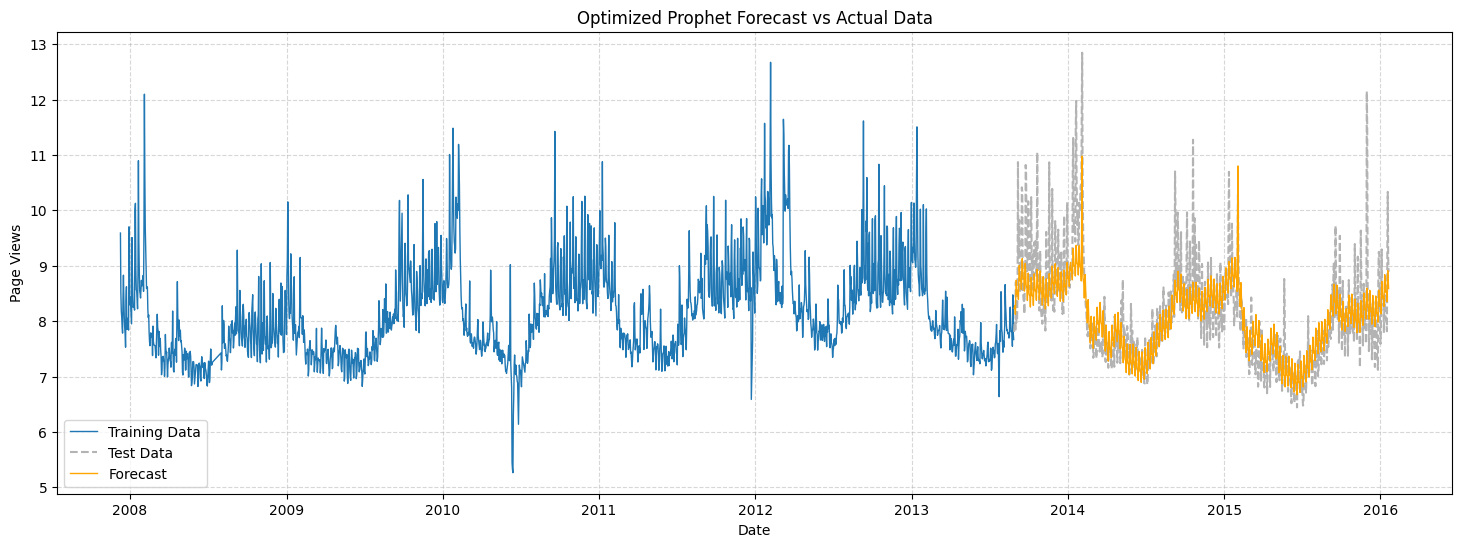

In [ ]:
# 探索された最適なハイパーパラメータを使ってモデルを再構築
best_params = study.best_params

# holidaysを再定義(holidaysの定義を常にスコープ内で利用可能にする必要があり)
holidays = pd.DataFrame({
            'holiday': 'Superbowl',
            'ds': pd.to_datetime(['2008-02-03', '2009-02-01', '2010-02-07', '2011-02-06', '2012-02-05', '2013-02-03', '2014-02-02', '2015-02-01']),
            'lower_window': 0,
            'upper_window': 1
})

model_op = Prophet(
    seasonality_mode='additive',
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    n_changepoints=best_params['n_changepoints'],
    changepoint_range=best_params['changepoint_range'],
    holidays=holidays
)

# モデルの学習
model_op.fit(train_df)

# テストデータの期間に対する予測
future = test_df[['ds']]
forecast = model_op.predict(future)

# 予測結果と実データの可視化
plt.figure(figsize=(18, 6))
# 学習データ
plt.plot(train_df['ds'], train_df['y'], label='Training Data', linewidth=1)
# テストデータ
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='0.7', linestyle='dashed')
# 予測結果
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange', linewidth=1)
plt.title('Optimized Prophet Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

グラフから精度が改善されたことが分かります。
予測精度を評価するために、RMSE、MSE、MAE、MAPEを計算します。

In [ ]:
# 実測値と予測値を取得
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

# 各評価指標を計算
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# 結果を表示
print(f"MSE: {round(mse, 3)}")
print(f"RMSE: {round(rmse, 3)}")
print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}")

MSE: 0.281
RMSE: 0.53
MAE: 0.359
MAPE: 0.042


ハイパーパラメータチューニングにより各評価指標が大幅に改善されました。<br>
MSE： 1.069 → 0.281<br>
RMSE： 1.034→ 0.53<br>
MAE： 0.879→ 0.359<br>
MAPE： 0.106→ 0.042<br>

Prophetは、デフォルトパラメータ設定でも簡単に実装できますが、パラメータチューニングを行うことでモデル精度のさらなる向上が期待できます。

# <font color="DarkOrange">3. SARIMA（季節性ARIMA）</font>

## <font color="SeaGreen">SARIMAとは</font>
<font color="red">ARIMAには、季節的なパターンを十分に反映できないという欠点があります。この欠点を補うために登場したのが、SARIMA（Seasonal ARIMA）モデルです。</font>

SARIMAモデルは、自己回帰（AR）、階差（I）、移動平均（MA）を組み合わせたARIMAモデルに、**季節的な変動要素（Seasonal Component）**を追加したものです。その結果、季節性の影響をより効果的に捉えることができます。

SARIMAには季節性やトレンドを表す複数のパラメータがあり、最適なパラメータを赤池情報量規準 (AIC) に基づき求めます。今回はグリッドサーチ（全探索）を行います。

#### グリッドサーチ（Grid Search）とは
ハイパーパラメータの最適な組み合わせを見つけるための探索手法です。機械学習モデルにおいて、ハイパーパラメータを異なる値で試行し、**すべての組み合わせを網羅的に探索する**ことで、モデルの性能を最大化する設定を見つけます。

ここでもこれまで利用してきたAir Passengers Datasetを利用します。<br>
学習データ：テストデータ = 1：1 とします。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/AirPassengers.csv',
                   index_col='Month',
                   date_parser=dateparse,
                   dtype='int')

data.index = data.index.to_period('M')

data_log = np.log(data)

<ipython-input-3-d7a6e4634561>:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/AirPassengers.csv',


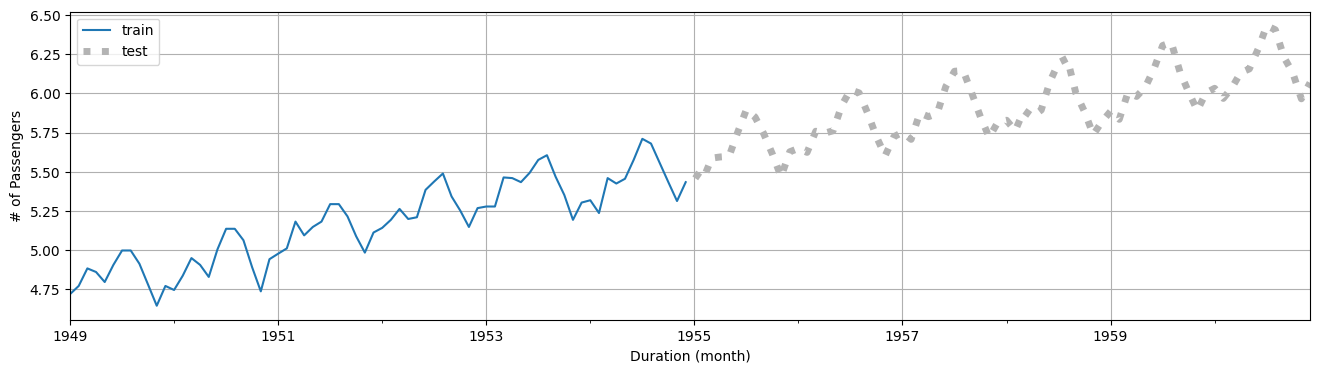

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# split data into train and test
from sklearn.model_selection import train_test_split
train_size = 0.5
train, test = train_test_split(data_log, train_size=train_size, shuffle=False)

# plot train and test data
ax1 = train.plot(label='train', figsize=(16,4))
test.plot(label='test',
            color="0.7",
            linestyle='dotted',
            linewidth="5.0",
            ax=ax1)
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
ax1.legend(['train', 'test'])
plt.grid(True)
plt.show()

In [ ]:
# search best parameters for SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm

# parameters for SARIMA
# s: seasonality (S)
# p: regression  (AR)
# d: difference  (I)
# q: error       (MA)
s = 12 # month
p = d = q = range(0, 2)
sp = sd = sq = range(0, 2)

# (p, d, q) and (P, D, Q, s) combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(sp, sd, sq))]

# grid search
best_params = [0, 0, 10000000]
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                     order = param,
                     seasonal_order=param_seasonal,
                     enforce_stationarity=True,
                     enforce_invertibility=True)

            # fitting
            results = mod.fit(disp=False)

            # update best parameters based on AIC
            if results.aic < best_params[2]:
                best_params = [param, param_seasonal, results.aic]
        except:
            pass

print('Best model parameters:', best_params)

  0%|          | 0/8 [00:00<?, ?it/s]

Best model parameters: [(0, 1, 1), (1, 0, 1, 12), -209.56861927399828]


パラメータが求められたので、時系列データをモデリングし将来の乗客数を予測してみましょう。かなり良い予測結果ですね。

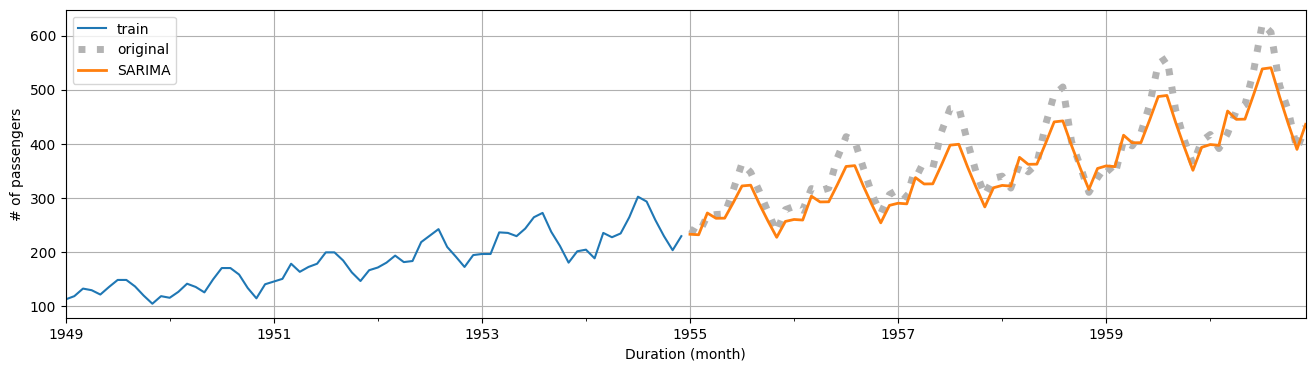

In [ ]:
# fitting
sarima = SARIMAX(
    train,
    order=best_params[0],
    seasonal_order=best_params[1],
    enforce_stationarity = False,
    enforce_invertibility = False
).fit(disp=False)

# forecasting window
#st = pd.to_datetime(test.index[0])
#ed = pd.to_datetime(test.index[-1])
st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

# forecasting
sarima_pred = sarima.predict(st, ed)

# plot figure
ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(sarima_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'SARIMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

# <font color="DarkOrange">4. 状態空間モデル(Linear Dynamical System)</font>

## <font color="SeaGreen">状態空間モデルとは</font>
線形動的モデルもまた、SARIMAのような統計モデルの一種です。しかしながら、線形動的モデルは前章で説明したAR, MA, ARIMA, SARIMAのようなモデルを含む、さまざまな統計モデルも統一的に表すことが可能です。そして、それらの統計モデルの欠点を補うこともできます。例えば、データに欠損が存在する場合、SARIMAで推定することはできませんが、線形動的モデルを用いれば可能です。直近数ヶ月はデータが取れていたのに、一週間前だけサーバの不具合でデータが取れていなかったとき、どのようにしてデータを予測するでしょうか。
* 直近一週間のみのデータを使用し、過去のデータの使用は諦める
* またデータが数ヶ月蓄積されるのを待つ
* 「いい感じの値」でデータを補完して予測する  

など色々考えられますが、なんかダサいですよね。<font color="red">データが一部存在しなくても、過去の「状態」を推定することで未来の「状態」との関連性をモデル化し、将来の「観測値」を予測可能なものが線形動的モデルです。</font>

例えば、将来の各家庭での電力消費量を予測したいとします。これまでの数年分のデータが存在するとして、そのデータは必ず変動しているはずです。では、そのデータの変動の「原因」はなんなのでしょうか。気候変化かもしれませんし、電力自由化に伴う電気代の変動かもしれません。家族がいた場合そのうち一人が大学進学で家を出て行ったかもしれません。しかしこれらの「原因」はデータから直接「観測」することはできません。そこで、データの変動を直接観測できない「状態変化」と「誤差」に分けて考えるのが線形動的モデルです。電力消費量の変化が、各家庭や社会情勢、経済、気候の「状態変化」によるものなのか、それとも「誤差」による変動なのかモデルで表現することができます。

そのため、線形動的モデルでは状態方程式と観測方程式と呼ばれる二つの式を構築します。まずは状態方程式の推定です。初期状態 $z(t)$ が与えられたとして、その次の状態を推定します。ここでは、前の状態と似た状態だろうな、と考えることにします（もちろんそれ以外の考え方もあります）。SARIMAにおけるAR（自己回帰）部分も同じ考え方です。前の状態は大量の電力消費を促す状態だったので、次もそうだろう、と考え、 $z(t+1) = z(t)$ と予測しました。

次は観測値の推定です。次の年、あるいは月の実際の電力消費量はまだわからないけれど、推定した状態から予測してみよう、と試みます。前の状態とよく似ているんだから、次の時刻での観測値も同じようなものだろう、と予測値 $f(t+1)$ 予測しました。しかし予測結果と後々観測された実際の値を比べたとき、予測値は観測値と大きくずれていたとします。でも大丈夫です。実際に観測された値から、推定した状態を以下のように補正します。
* $補正された状態 z(t+1)' = 補正前の状態 z(t+1) + カルマンゲイン k(t+1) × (本物の観測値v(t+1)-予測された観測値 f(t+1))$

ここでカルマンゲイン $k(t+1)$ とは、時刻t+1での補正の強さを表します。

以上のように、
1. 次の状態 $z(t+1)$ の推定
1. 次の状態 $z(t+1)$ に基づく予測された観測値 $f(t+1)$ の推定
1. 実際の観測値 $v(t+1)$ による状態 $z(t+1)$ の補正 $z(t+1)$

を繰り返し予測し続けるのが線形動的モデルです。潜在的な状態から次の潜在的な状態を推定し続けるので、欠損値があってもOKです。実際に線形動的モデルを動かしてみましょう。

#### ローカルレベルモデル
まずは、一番単純な状態空間表現を考えましょう。次の状態は一つ前の状態と同じであり、その状態から観測値を予測します。そうすると、同じデータが予測され続けるはずです。
* 潜在状態 $z(t+1) = z(t)$
* 推定観測値 $v(t+1) = z(t+1)$

こんなはずはありません。そこで観測値のノイズ $w$ を追加します。
* 潜在状態 $z(t+1) = z(t)$
* 推定観測値 $v(t+1) = z(t+1) + w(t+1)$

しかしこれでも不十分で、こうすると観測値はノイズの分散だけブレるだけで、状態が変化することはありません。そこで潜在状態にもノイズ $e$ を追加します。
* 潜在状態 $z(t+1) = z(t) + e(t+1)$
* 推定観測値 $v(t+1) = z(t+1) + w(t+1)$

こうすることで潜在状態が変化し、一定の値から上下にブレるだけではなくなりました。実装してみます。

ここでもこれまで利用してきたAir Passengers Datasetを利用します。


Optimization terminated successfully.
         Current function value: -0.840594
         Iterations: 41
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.840594
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3


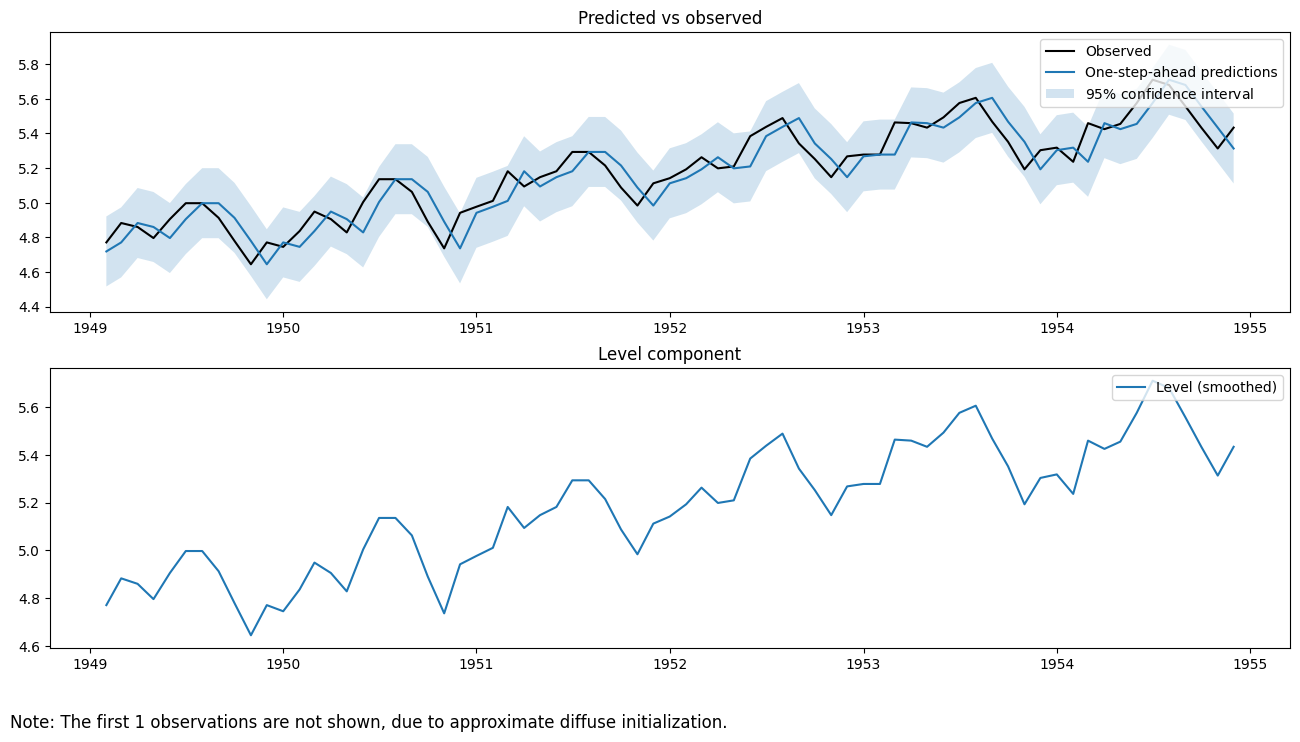

In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

# インデックス（PeriodIndex）を日付データであるDatetimeIndexに変換
train.index = train.index.to_timestamp()

# local level model
local_level_model = UnobservedComponents(train, 'llevel')

# parameter estimation with maximum likelihood estimation
local_level_params = local_level_model.fit(
                        method='bfgs',
                        maxiter=500,
                        start_params=local_level_model.fit(method='nm', maxiter=500).params)

# show summary
#print(local_level_params.summary())

# plot summary
fig = local_level_params.plot_components(figsize=(16, 8))


微妙ですね。これでは、「予測値は一つ前の観測値と同じ」といった予測結果になります。ここで次のようにトレンドを捉えてみましょう。
* トレンド $T(t+1) = T(t) + トレンド誤差u(t)$
* 潜在状態 $z(t+1) = z(t) + T(t) + e(t)$
* 推定観測値 $v(t+1) = z(t+1) + w(t+1)$

Optimization terminated successfully.
         Current function value: -0.625886
         Iterations: 56
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.796914
         Iterations: 17
         Function evaluations: 36
         Gradient evaluations: 36


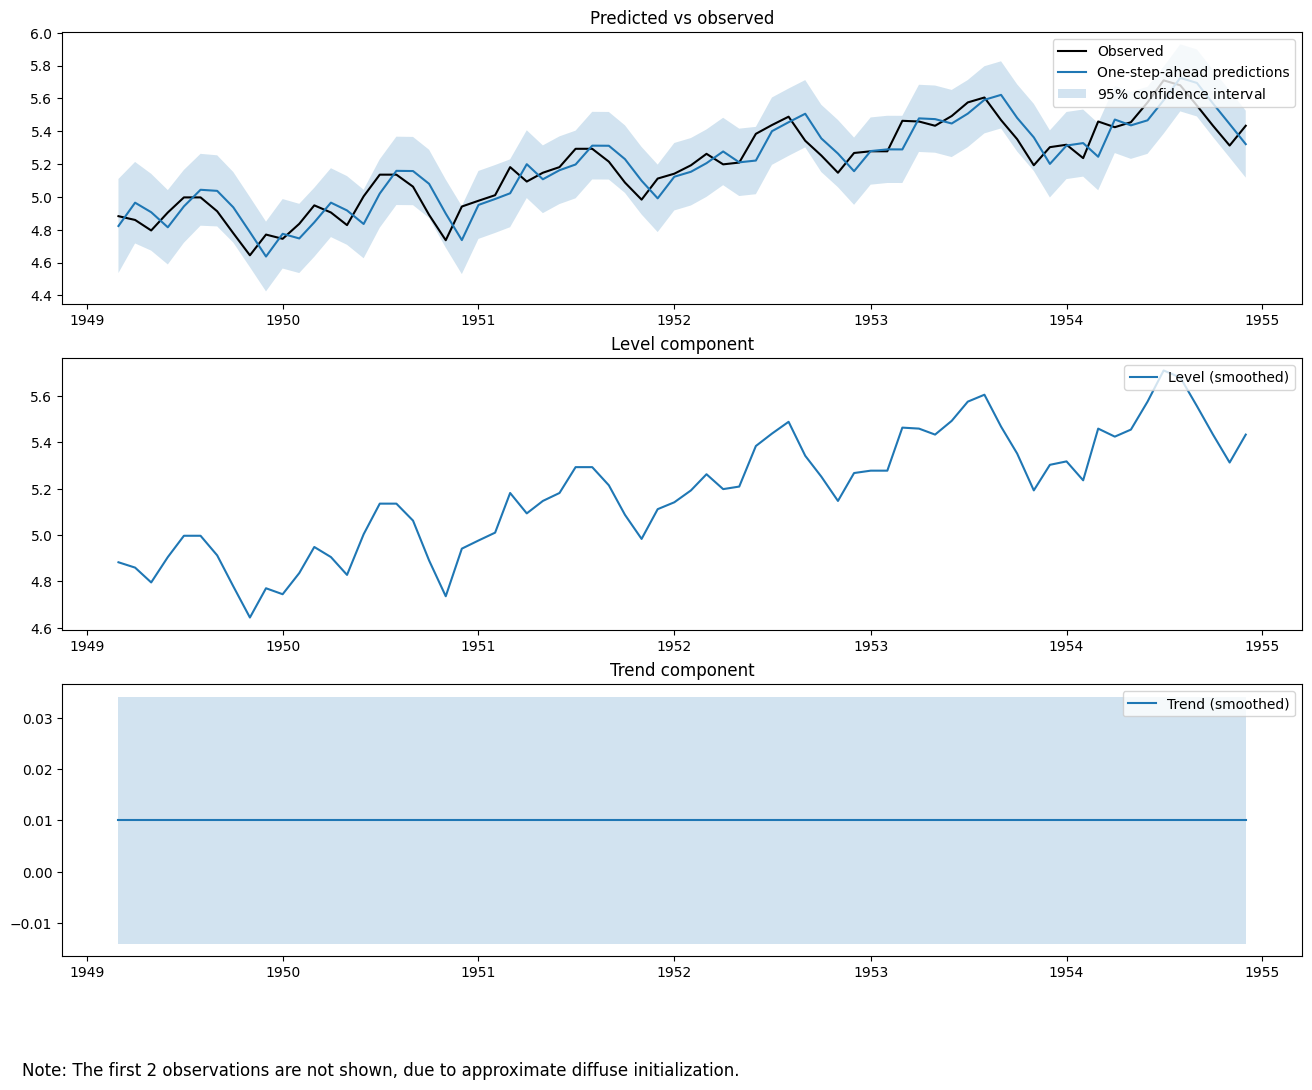

In [ ]:
# local linear trend model
trend_model = UnobservedComponents(train, 'lltrend')

trend_params = trend_model.fit(method='bfgs',
                        maxiter=500,
                        start_params=trend_model.fit(method='nm', maxiter=500).params)

# print(trend_params.summary())
fig = trend_params.plot_components(figsize=(16,12))

これでもうまく捉えらきれていません。季節成分を自明にとっていないので、状態成分で無理矢理季節性とトレンドを抽出しているようです。そこで季節性を自明にとってみます。これでほぼSARIMA (しかも高速) です。(詳しくは[statsmodels.tsa.statespace.structural.UnobservedComponents](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html))
* 推定観測値 $v(t+1) = z(t+1) + T(t+1) + S(t+1) + noises$

Optimization terminated successfully.
         Current function value: -1.329239
         Iterations: 127
         Function evaluations: 224
         Current function value: -1.372075
         Iterations: 12
         Function evaluations: 89
         Gradient evaluations: 77


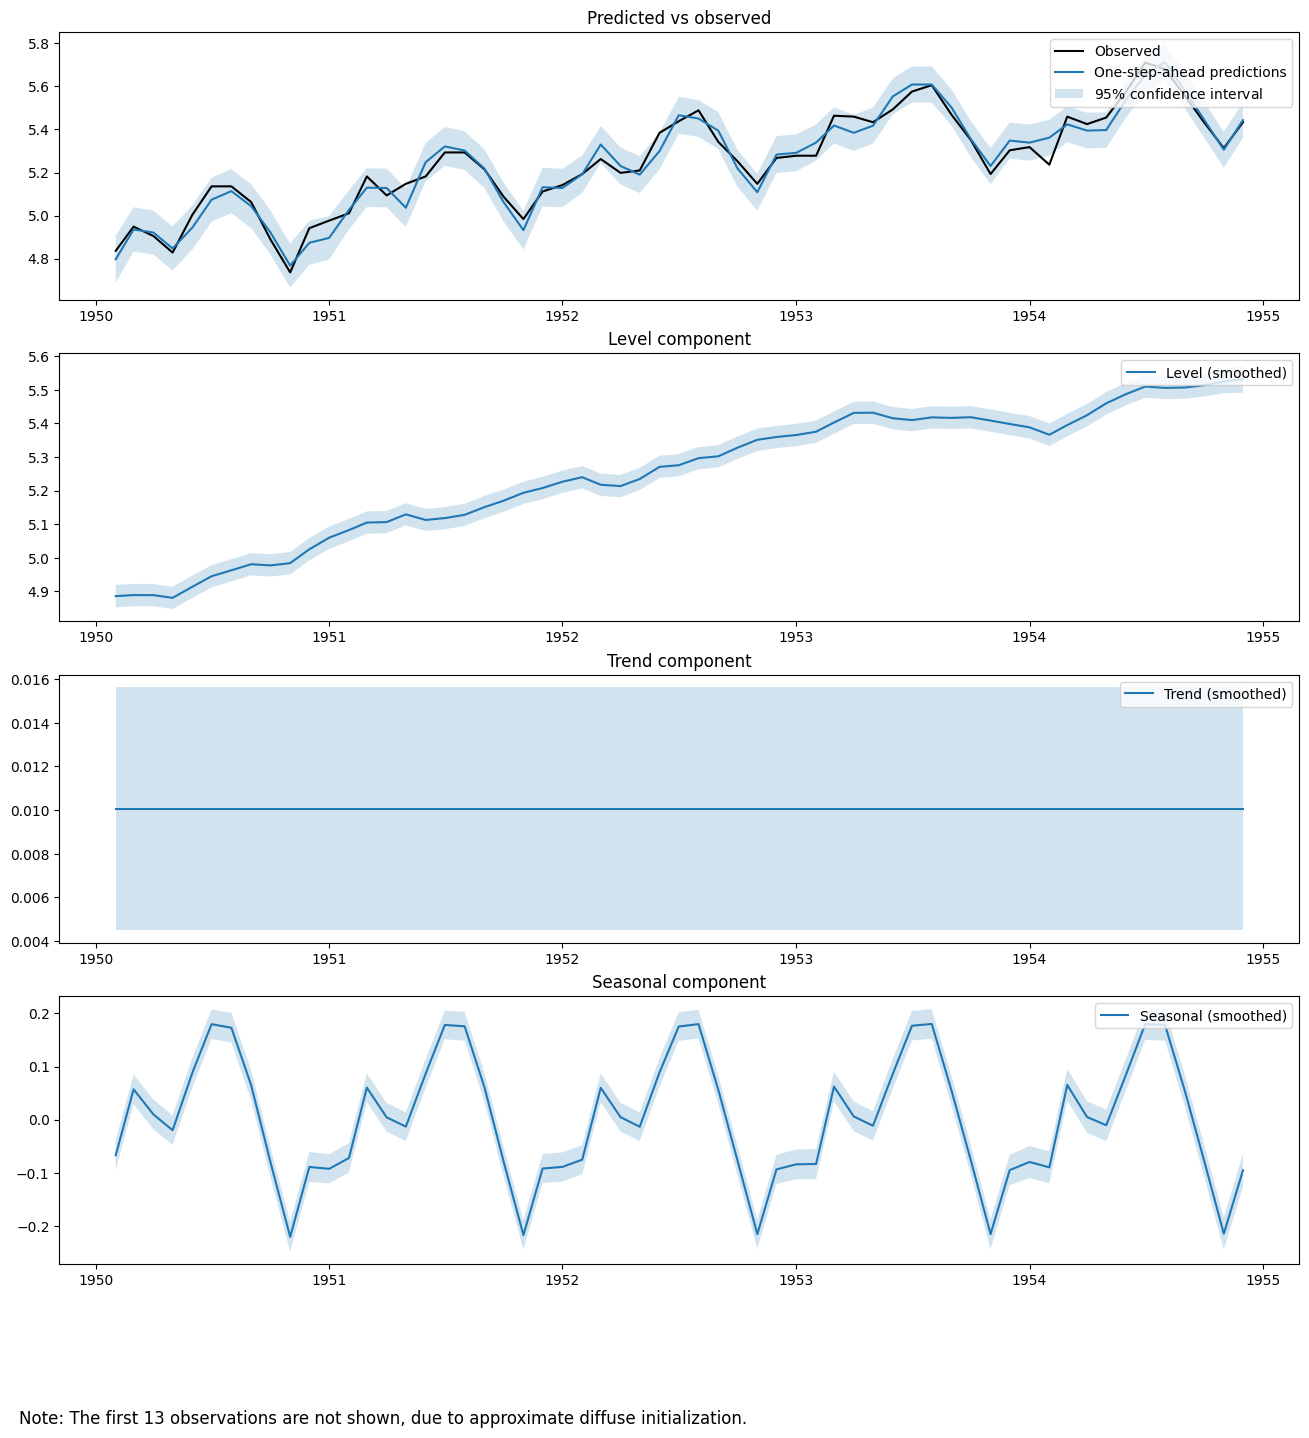

In [ ]:
# local level model with seasonality
seasonal_model = UnobservedComponents(train, 'lltrend', seasonal=12)

# parameter estimation with maximum likelihood estimation
seasonal_params = seasonal_model.fit(method='bfgs',
                        maxiter=500,
                        start_params=seasonal_model.fit(method='nm', maxiter=500).params)

# show summary
# print(seasonal_params.summary())

# plot summary
fig = seasonal_params.plot_components(figsize=(16, 16))

かなり綺麗にモデリングできています。実際に予測してみましょう。

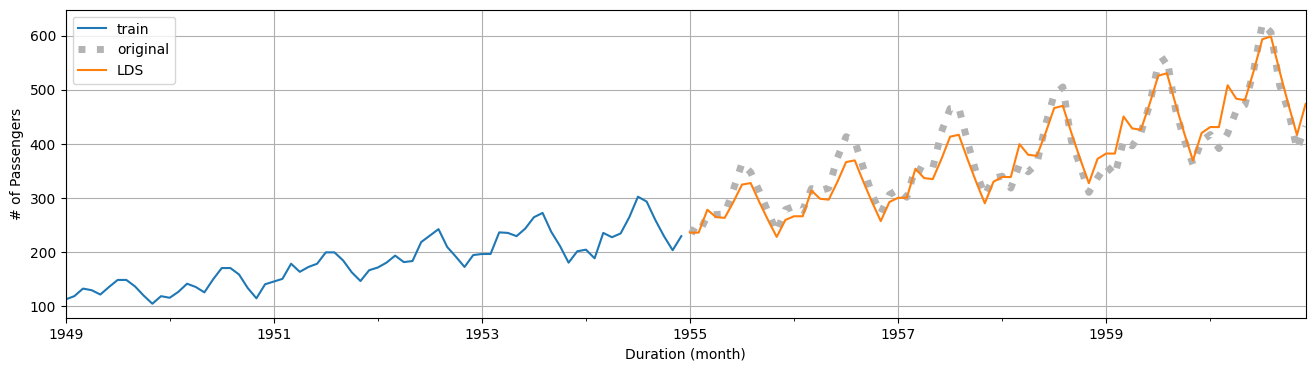

In [ ]:
# forecast future values
statespace_pred = seasonal_params.predict(st, ed)

# plot results
ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color="0.7",
          linestyle='dotted',
          linewidth="5.0",
          ax=ax1)

np.exp(statespace_pred).plot(ax=ax1)


plt.legend(['train', 'original', 'LDS'])
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
plt.grid(True)
plt.show()

非常に良好な結果が得られました。

# <font color="DarkOrange">5. モデルの特徴まとめ</font>
時系列データの予測には、さまざまなモデルが用いられます。データの特性や目的に応じて適切なモデルを選ぶことで、より正確で意味のある予測が可能になります。
これまで学んできた時系列解析のモデルの特徴について表にまとめます。

| **モデル** | **特徴** | **予測精度（短期）** | **予測精度（長期）** | **手軽さ** | **主な用途** | **その他特徴** |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| ARIMA系 | AR+I+MAで時系列データをモデル化 | 高い | 限定的 | 手動でパラメータ選択が必要 | 売上予測、需要予測、金融データ | 季節性に弱い（SARIMAを利用すれば季節性を捉えることが可能） |
| VAR | 複数の時系列データ間の相互依存関係をモデル化 | 高い（多変量データで有利） | 限定的 | データ次第で難易度が変わる |マクロ経済データ、金融システム分析 | 全ての変数が互いに影響を与え合うため次元が多いと計算負荷が高くなる |
| Prophet | トレンド、季節性、イベントの影響を自動的に分解し簡単に予測可能 | 高い | 高い | データの前処理がほとんど不要で、かつ、デフォルト設定で十分動作可能 | マーケティング、売上、需要、Webトラフィック | 外れ値や休日の影響を強力にモデル化可能なため非定常データに対しても安定的 |
| LDS | 観測されない内部状態を動的にモデル化し、カルマンフィルタで最適な状態を推定 | 高い | 高い | データの前処理が必要な場合が多い | ロボット制御、交通、気象予測 | ノイズ除去に優れていて、非線形システムには拡張カルマンフィルタや粒子フィルタを用いることで対応可能 |

<br>
<br>
時系列データ解析には、データの特性や目的に応じて適切なモデルを選ぶことが重要です。短期予測にはARIMAやVARが強い一方で、長期的なトレンドや複雑な動的システムにはProphetやLDSが効果的です。また、特定のイベントや季節性の影響が強い場合には、Prophetのような柔軟なモデルが適しています。予測精度を高めるためには、これらのモデルの特徴を理解し、必要に応じてハイパーパラメータを適切にチューニングすることが求められます。
